<a href="https://colab.research.google.com/github/galvaowesley/DataScience_Learning/blob/master/minicurso_dataScience/Semana_9/indices_socioeconomicos_brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Análise de índices socioecônomicos - Brasil
===
Julho, 2020

Wesley Galvão

# Introdução

Este trabalho apresenta uma breve análise e visualização de dados de índices socioeconômicos do Brasil, como: PIB e suas componentes, seguro desemprego, IPCA, Selic e taxa de câmbio. 

Foram utilizados três fontes para os conjuntos de dados, que serão mencionados no decorrer da leitura. 

# Instalação e carregamento de pacotes

A análise conta com técnicas de manipulação e visualização de dados, portanto, seguem os pacotes que foram necessários. 

In [ ]:
# Instalação de pacotes
install.packages(c('devtools', 'ggplot2','tidyr', 'scales', 'ggpubr', 
                   'gridExtra', 'dynlm', 'plotly', 'readxl', 'reshape2'))
# Instalação dos pacotes que contêm os conjuntos de dados
install.packages('sidrar')

In [ ]:
# Carregamento de pacotes e base de dados
library(ggplot2)
library(reshape2) # Melt correlation matrix
library(tidyr)
library(gridExtra)
library(dynlm)
library(plotly)
library(readxl)
library(sidrar)
library(ggpubr)
library(lubridate)

# Configuração do ambiente
options(warn=-1)
options(repr.plot.width = 14, repr.plot.height = 8)

theme = 
  theme_minimal() +
  theme(
    plot.title    = element_text(size=18, face="bold", color="gray30"),
    plot.subtitle = element_text(size=15, color="gray30"),
    axis.title    = element_text(size=15, color="gray30"),
    axis.text     = element_text(size = 13),
    plot.caption  = element_text(size=15, color = "gray60"),
    legend.text   = element_text(size=15, color="gray30"),
    legend.title  = element_text(size=15, color="gray30"),
    strip.text.x  = element_text(size=13, color="gray30")
  )

# Produto Interno Bruto

Os dados referentes ao PIB e suas componentes foram obtidos a partir do pacote SIDRAR. SIDRAR é uma interface os dados disponibilizados pela plataforma [Sistema IBGE de Recuperação Automática](https://sidra.ibge.gov.br/home/ipca/brasil). Contém importantes índices socioeconômicos, como IPCA15 e PIB.

Através de uma API e com parâmetros pré-estabelecidos, foram obtidas as séries com e sem ajuste sazonal do PIB. Para saber mais sobre o que é ajuste sazonal, leia este artigo: [Ajuste Sazonal](https://pt.qwe.wiki/wiki/Seasonal_adjustment).


### Conhecendo os dados
As duas séries contêm as componentes que contribuem para o PIB e o próprio PIB: 
#### Dicionário

- `agropecuaria` : Agropecuária - total
- `desp_gov`  :  Despesa de consumo da administração pública 
- `desp_fam` : Despesa de consumo das famílias 
- `exportacao` : Exportação de bens e serviços
- `fbcf` : Formação bruta de capital fixo
- `importacao` : Importação de bens e serviços (-)
- `industria` : Indústria - total 
- `pib` : PIB a preços de mercado 
- `servicos`  : Serviços - total

In [202]:
# Importação de dados sem ajustes sazonais
tabela_pib = get_sidra(api='/t/1620/n1/all/v/all/p/all/c11255/90687,90691,90696,90707,93404,93405,93406,93407,93408/d/v583%202') %>%
  mutate(date = as.yearqtr(`Trimestre (Código)`, format='%Y%q')) %>%
  select(date, `Setores e subsetores`, Valor) %>%
  spread(`Setores e subsetores`, Valor) %>%
  rename(`agropecuaria`=`Agropecuária - total`,
         `desp_gov` = `Despesa de consumo da administração pública`, 
         `desp_fam` = `Despesa de consumo das famílias` ,
         `exportacao` = `Exportação de bens e serviços`,
         `fbcf` = `Formação bruta de capital fixo`,
         `importacao` = `Importação de bens e serviços (-)`,
         `industria` = `Indústria - total`, 
         `pib` = `PIB a preços de mercado`, 
         `servicos` = `Serviços - total`) %>%
  as_tibble()

# Estrutura da série
tail(tabela_pib, 3)
# Dimensões
cat("Número de linhas: ", dim(tabela_pib)[1])
cat("\nNúmero de colunas: ", dim(tabela_pib)[2])

All others arguments are desconsidered when 'api' is informed



date,agropecuaria,desp_gov,desp_fam,exportacao,fbcf,importacao,industria,pib,servicos
<yearqtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019 Q3,222.42,147.40,183.30,315.65,157.39,279.42,140.31,172.89,179.01
2019 Q4,155.49,151.24,189.87,310.98,145.43,256.25,135.37,171.17,181.34
2020 Q1,284.18,142.87,175.75,284.46,143.96,248.71,125.59,165.39,171.36


Número de linhas:  97
Número de colunas:  10

In [203]:
# Importação de dados com ajustes sazonais
tabela_pib_sa = get_sidra(api='/t/1621/n1/all/v/all/p/all/c11255/90687,90691,90696,90707,93404,93405,93406,93407,93408/d/v584%202') %>%
  mutate(date = as.yearqtr(`Trimestre (Código)`, format='%Y%q')) %>%
  select(date, `Setores e subsetores`, Valor) %>%
  spread(`Setores e subsetores`, Valor) %>%
  rename(`agropecuaria_sa`=`Agropecuária - total`,
         `desp_gov_sa` = `Despesa de consumo da administração pública`, 
         `desp_fam_sa` = `Despesa de consumo das famílias` ,
         `exportacao_sa` = `Exportação de bens e serviços`,
         `fbcf_sa` = `Formação bruta de capital fixo`,
         `importacao_sa` = `Importação de bens e serviços (-)`,
         `industria_sa` = `Indústria - total`, 
         `pib_sa` = `PIB a preços de mercado`, 
         `servicos_sa` = `Serviços - total`) %>%
  as_tibble()

# Estrutura da série
tail(tabela_pib_sa, 3)
# Dimensões
cat("Número de linhas: ", dim(tabela_pib_sa)[1])
cat("\nNúmero de colunas: ", dim(tabela_pib_sa)[2])

All others arguments are desconsidered when 'api' is informed



date,agropecuaria_sa,desp_gov_sa,desp_fam_sa,exportacao_sa,fbcf_sa,importacao_sa,industria_sa,pib_sa,servicos_sa
<yearqtr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2019 Q3,231.16,146.88,182.41,300.07,149.61,259.44,133.79,170.08,177.02
2019 Q4,230.21,147.49,183.17,306.87,145.59,250.83,133.82,170.70,178.22
2020 Q1,231.52,147.84,179.54,304.07,150.10,257.87,131.97,168.07,175.30


Número de linhas:  97
Número de colunas:  10

### Análise das componentes

Primeiramente, analisaremos o grau de correlação entre as variáveis existentes. Para tal, usaremos a matrix de correlação que indica o coeficiente de Pearson para cada relação existente. 

Abaixo segue a função para obter o tringulo superior da matrix de correlação. O uso dessa função pode ser encontrado no artigo da [STHDA](http://www.sthda.com/english/wiki/ggplot2-quick-correlation-matrix-heatmap-r-software-and-data-visualization).

In [ ]:
# Get upper triangle of the correlation matrix
  get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }

Construção da matrix de corelação e do gráfico heatmap. 

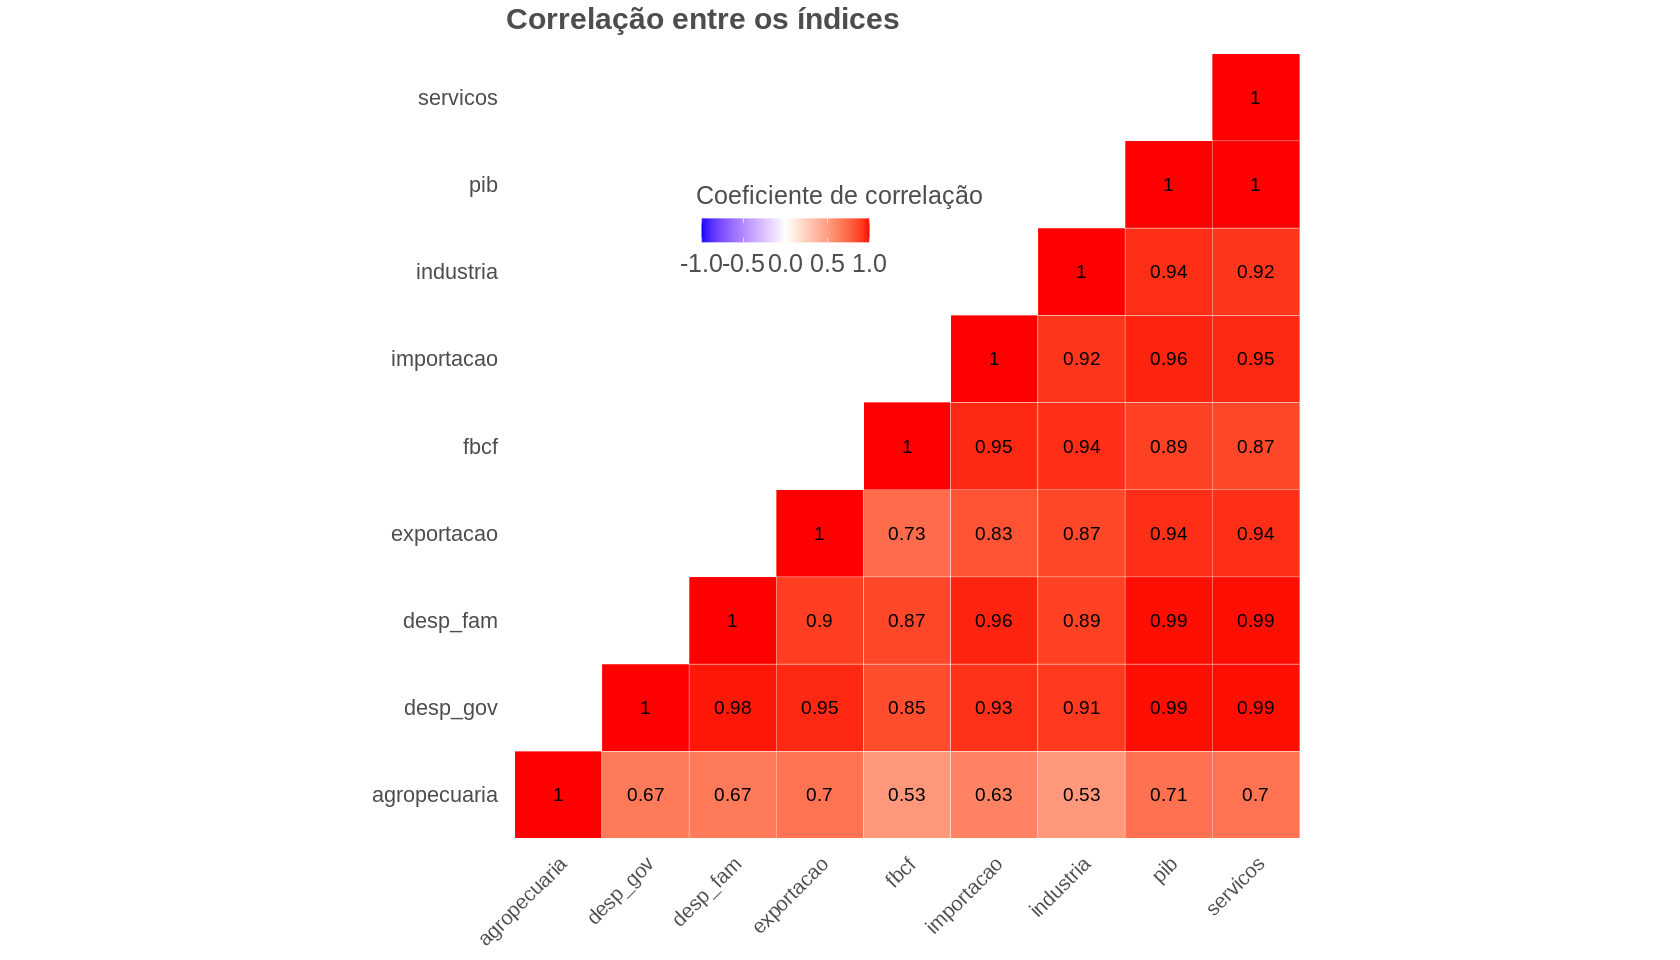

In [6]:
# Matrix de correlação
cormat <- round(cor(tabela_pib[, c(2:10)]),2)
upper_tri <- get_upper_tri(cormat)
melted_cormat <- melt(upper_tri, na.rm = TRUE)

# Heatmap
 ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
     geom_tile(color = "white") +
     labs(title = "Correlação entre os índices") +
     scale_fill_gradient2(low = "blue", 
                          high = "red", 
                          mid = "white", 
                          midpoint = 0, 
                          limit = c(-1,1), 
                          space = "Lab", 
                          name="Coeficiente de correlação") +
     coord_fixed() + theme + 
     geom_text(aes(Var2, Var1, label = value), color = "black", size = 4) +
     theme(
      axis.text.x = element_text(angle = 45, vjust = 1,size = 12, hjust = 1),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.grid.major = element_blank(),
      panel.border = element_blank(),
      panel.background = element_blank(),
      axis.ticks = element_blank(),
      legend.justification = c(1, 0),
      legend.position = c(0.6, 0.7),
      legend.direction = "horizontal")+
      guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                    title.position = "top", title.hjust = 0.5))

Nota-se um forte grau de correlação entre todas as váriáveis. Isso indica uma forte dependência do PIB com as suas componentes. 

Façamos agora a evolução de cada variável ao longo do tempo, primeiramente com o conjunto de dados sem o ajuste sazonal. 

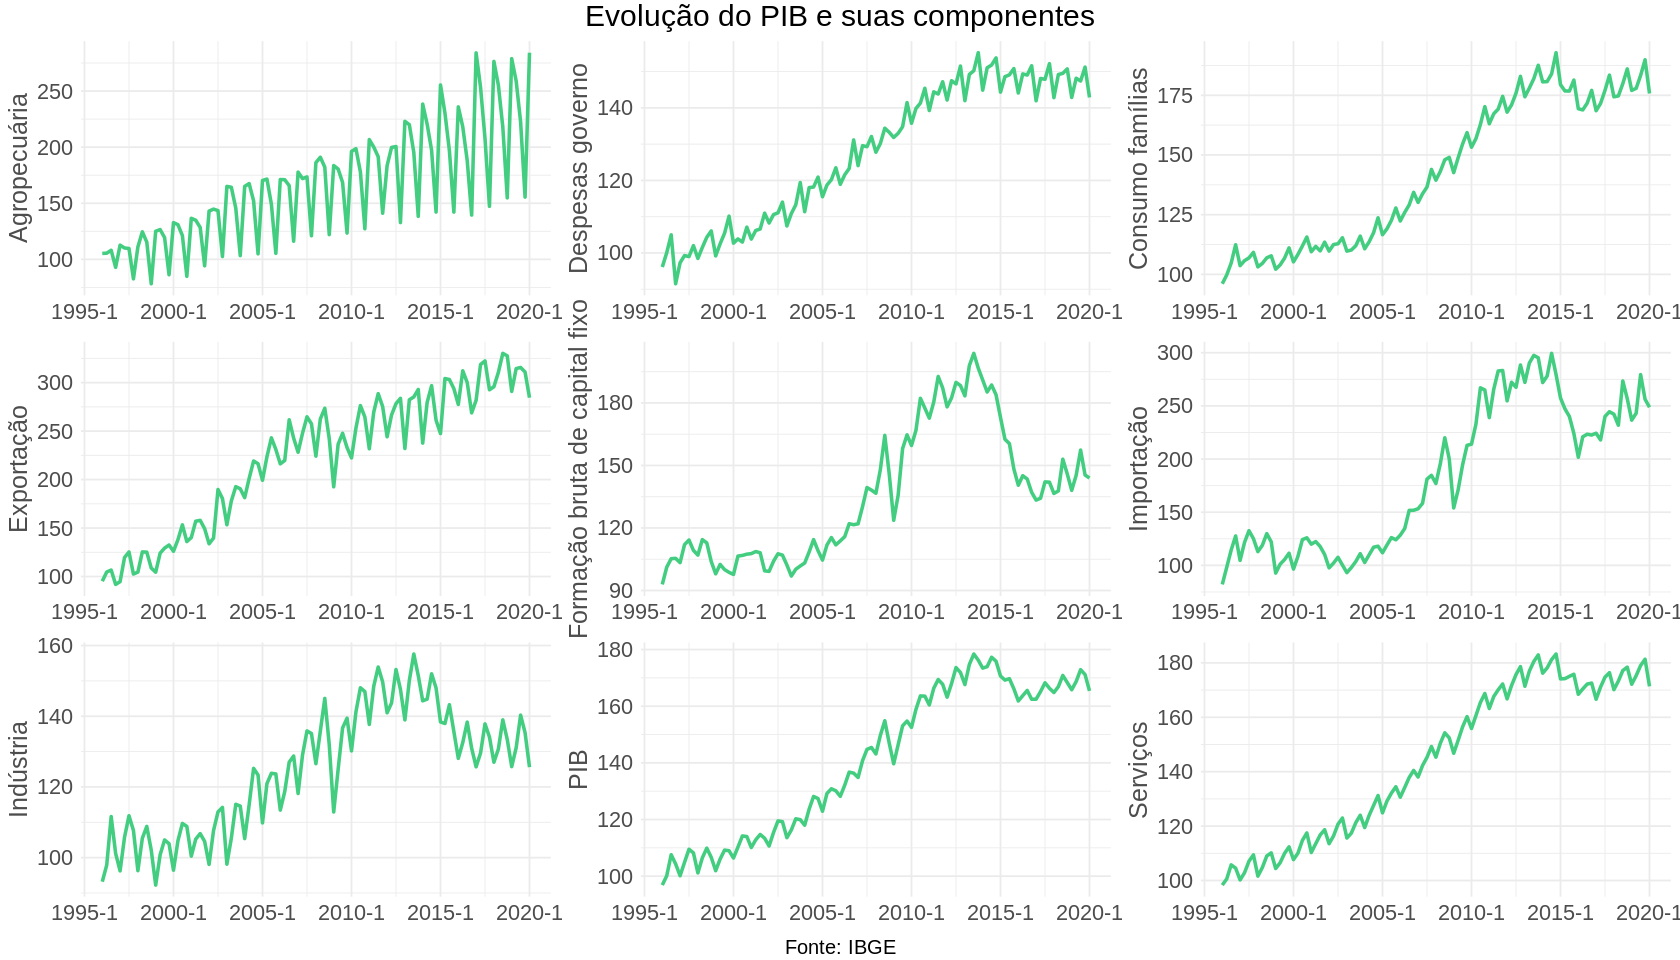

In [7]:
# plots das componentes do PIB a partir do conjunto de dados sem ajustes sazonais 

p1 = ggplot(tabela_pib, aes(x = date, y = agropecuaria)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Agropecuária") + 
        theme  + theme(axis.title.x = element_blank())

p2 = ggplot(tabela_pib, aes(x = date, y = desp_gov)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Despesas governo") +
        theme  + theme(axis.title.x = element_blank())

p3 = ggplot(tabela_pib, aes(x = date, y = desp_fam)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Consumo famílias") +
        theme  + theme(axis.title.x = element_blank())

p4 = ggplot(tabela_pib, aes(x = date, y = exportacao)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Exportação") +
        theme  + theme(axis.title.x = element_blank())

p5 = ggplot(tabela_pib, aes(x = date, y = fbcf)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Formação bruta de capital fixo") +
        theme  + theme(axis.title.x = element_blank())

p6 = ggplot(tabela_pib, aes(x = date, y = importacao)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Importação") +
        theme  + theme(axis.title.x = element_blank())

p7 = ggplot(tabela_pib, aes(x = date, y = industria)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Indústria") +
        theme  + theme(axis.title.x = element_blank())

p8 = ggplot(tabela_pib, aes(x = date, y = pib)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "PIB") +
        theme  + theme(axis.title.x = element_blank())

p9 = ggplot(tabela_pib, aes(x = date, y = servicos)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Serviços") +
        theme  + theme(axis.title.x = element_blank())

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, nrow = 3, 
             top = text_grob('Evolução do PIB e suas componentes', size = 18), 
             bottom = 'Fonte: IBGE')


Agora com ajuste sazonal. 

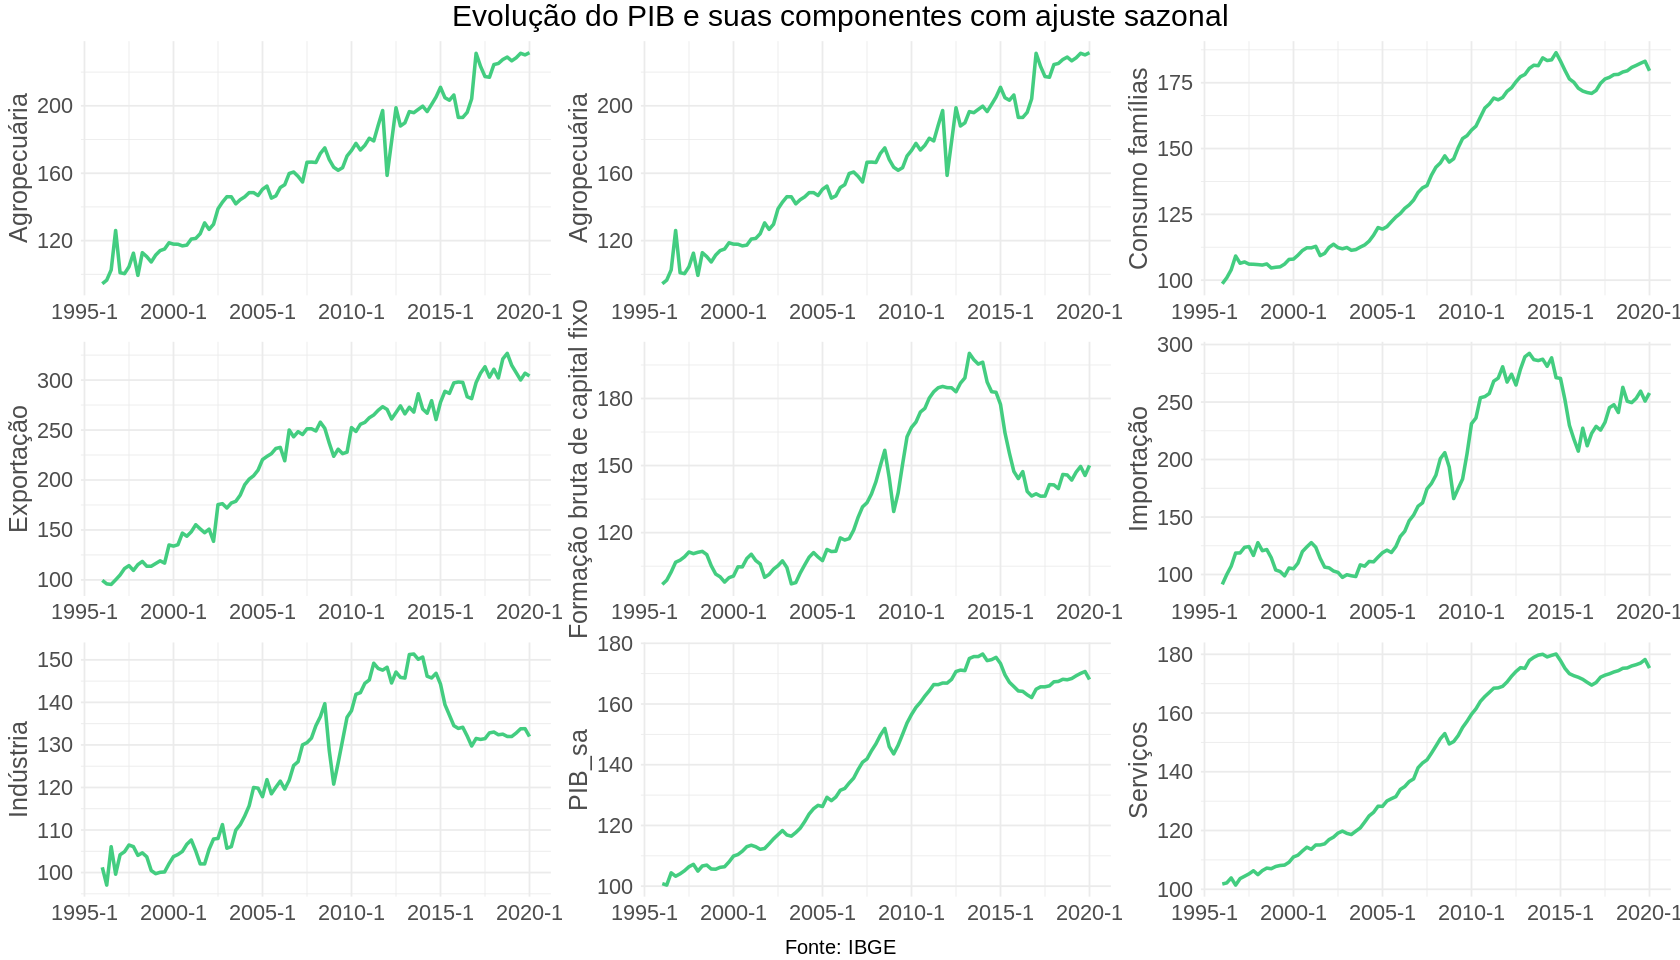

In [8]:
# plots das componentes do PIB a partir do conjunto de dados com ajustes sazonais 

p10 = ggplot(tabela_pib_sa, aes(x = date, y = agropecuaria_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Agropecuária") + 
        theme  + theme(axis.title.x = element_blank())

p11 = ggplot(tabela_pib_sa, aes(x = date, y = desp_gov_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Despesas governo") +
        theme  + theme(axis.title.x = element_blank())

p12 = ggplot(tabela_pib_sa, aes(x = date, y = desp_fam_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Consumo famílias") +
        theme  + theme(axis.title.x = element_blank())

p13 = ggplot(tabela_pib_sa, aes(x = date, y = exportacao_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Exportação") +
        theme  + theme(axis.title.x = element_blank())

p14 = ggplot(tabela_pib_sa, aes(x = date, y = fbcf_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Formação bruta de capital fixo") +
        theme  + theme(axis.title.x = element_blank())

p15 = ggplot(tabela_pib_sa, aes(x = date, y = importacao_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Importação") +
        theme  + theme(axis.title.x = element_blank())

p16 = ggplot(tabela_pib_sa, aes(x = date, y = industria_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Indústria") +
        theme  + theme(axis.title.x = element_blank())

p17 = ggplot(tabela_pib_sa, aes(x = date, y = pib_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "PIB_sa") +
        theme  + theme(axis.title.x = element_blank())

p18 = ggplot(tabela_pib_sa, aes(x = date, y = servicos_sa)) +
        geom_line(color = "seagreen3", size=1) +
        labs(y = "Serviços") +
        theme  + theme(axis.title.x = element_blank())

grid.arrange(p10, p10, p12, p13, p14, p15, p16, p17, p18, nrow = 3, 
             top = text_grob('Evolução do PIB e suas componentes com ajuste sazonal', size = 18) ,
             bottom = 'Fonte: IBGE')

Vejamos de perto como se comporta o PIB com e sem o ajuste num único gráfico. 

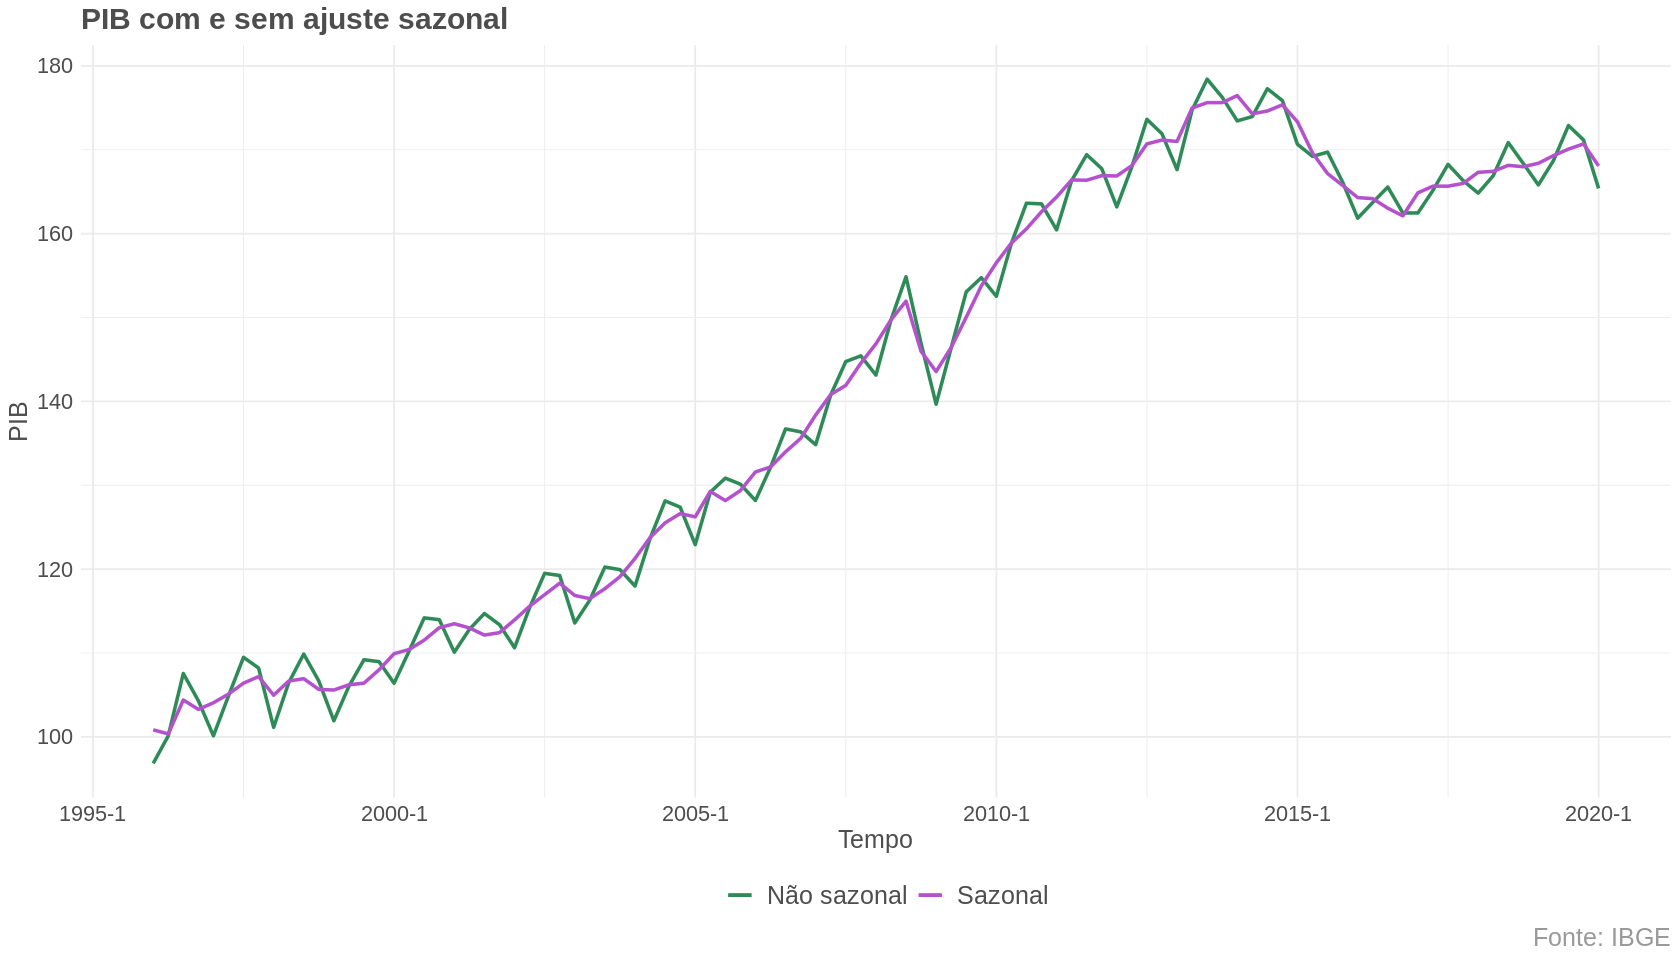

In [9]:
# Plot da série do PIB com e sem ajuste sazonal
ggplot(tabela_pib) +
    geom_line(mapping = aes(x = date, y = pib, color = "seagreen4"), size=1) +
    geom_line(mapping = aes(x = tabela_pib_sa$date, y = tabela_pib_sa$pib_sa, color = "mediumorchid3"), size=1) +
    labs(title = 'PIB com e sem ajuste sazonal',
         x = 'Tempo', 
         y = 'PIB', 
         caption = 'Fonte: IBGE') +
    scale_color_identity(
            name = " ",
            breaks = c("seagreen4", "mediumorchid3"),
            labels = c("Não sazonal", "Sazonal"),
            guide = "legend"
          ) +
    theme + theme(legend.position="bottom")

Outro índice interessante é o chamado **Taxa de investimento** que pode ser obtido pela razão entre os índices **Formacão Bruta de Capital Fixo (FBCF)** e o próprio **PIB**. 

Note no gráfico que há uma considerável queda na taxa de investimento a partir de 2015, e que aparenta ter uma leve recuperação no crescimento nos últimos anos. Esse resultado pode ter relação com o período de recessão que o país sofreu.  

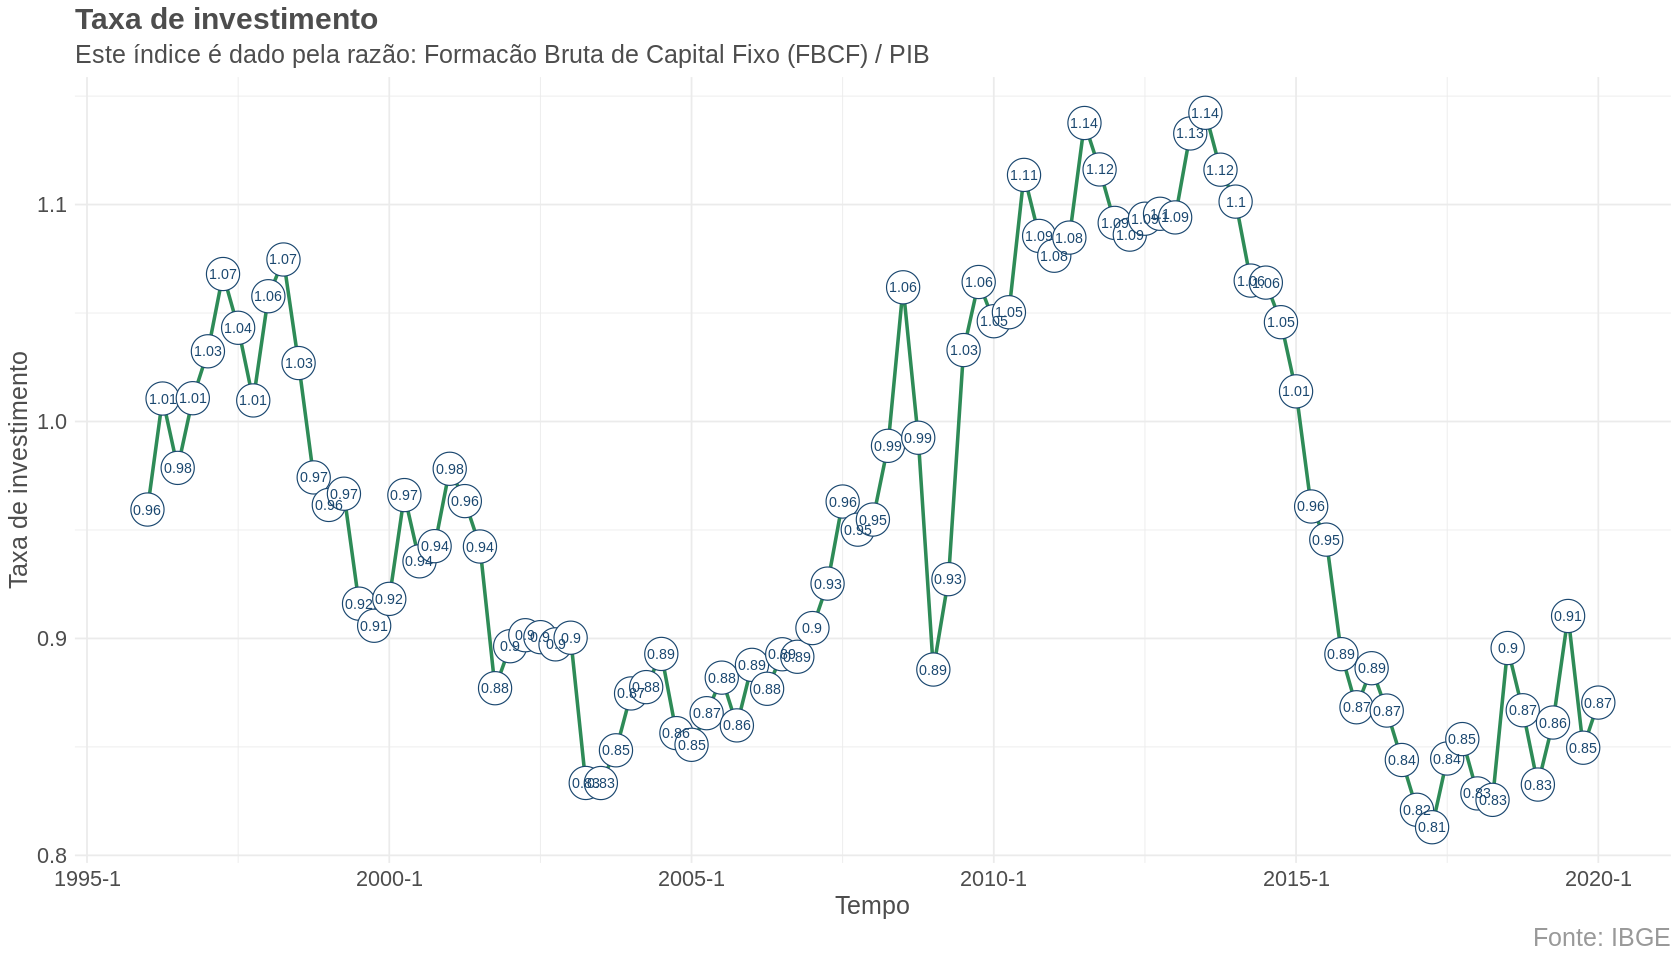

In [230]:
# Plot da taxa de investimento
ggplot(tabela_pib, aes(x = date, y = fbcf/pib)) +
    geom_line(color = "seagreen4", size=1) + 
    geom_point(size = 9, shape=21, colour="#1a476f", fill="white")+
    geom_text(aes(label = round(fbcf/pib, 2)), size = 3, hjust=0.5, vjust=0.5, shape=21, colour="#1a476f")+
    labs(title = 'Taxa de investimento',
         subtitle = 'Este índice é dado pela razão: Formacão Bruta de Capital Fixo (FBCF) / PIB',
         x = 'Tempo', 
         y = 'Taxa de investimento' , 
         caption = 'Fonte: IBGE'         
         ) +  
    theme 



---


# Seguro-desemprego

O seguro-desemprego é um importante benefício integrante da seguridade social, que provêm assistência financeira temporária ao trabalhador dispensado involuntariamente.

Nesta seção iremos visualizar a série de solicitações do seguro-desemprego ao longo do tempo em função das regiões e estados do país. 


## Importando e conhecendo os dados

Os dados foram obtidos pelo portal oficial do Ministério do Trabalho, chamado de [Programa de Dissiminação das Estatísticas do Trabalho](http://pdet.mte.gov.br). Os dados tiveram que ser reformatados para uma melhor manipulação, como se segue.

In [232]:
# Importação da base de dados
url = 'https://github.com/galvaowesley/DataScience_Learning/blob/master/minicurso_dataScience/Semana_9/3-%20S%C3%A9rie%20Hist%C3%B3rica%20do%20Seguro-Desemprego%20-%202000%20a%202020%20-%20mensal.xlsx?raw=true'
path = '/content/seguro.xlsx'

# Download
download.file(url, path, mode='wb')

# Leitura do arquivo
seguro_desemp = read_excel(path, sheet="Tabela 1", skip=5) %>% drop_na()
head(seguro_desemp, 6)

New names:
* `` -> ...1



...1,2000/01,2000/02,2000/03,2000/04,2000/05,2000/06,2000/07,2000/08,2000/09,⋯,2019/08,2019/09,2019/10,2019/11,2019/12,2020/01,2020/02,2020/03,2020/04,2020/05
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BRASIL,343398,375906,394778,347326,386524,354720,352319,376694,320982,⋯,567069,521572,553609,511025,434285,568609,483145,536844,748540,960258
ACRE,542,410,540,424,498,412,446,402,372,⋯,1162,1174,1239,1466,1160,1247,1287,1146,1293,1372
ALAGOAS,2219,2350,2584,2765,4479,2743,2807,2653,2104,⋯,5075,4430,4252,3913,3461,4318,4043,4673,5687,8247
AMAPA,522,567,533,456,521,565,567,544,425,⋯,1410,1164,1222,1090,878,1185,1103,998,918,1321
AMAZONAS,2945,3150,3085,2745,3281,2781,2978,3389,2518,⋯,5884,5535,5908,5905,4196,6680,5713,6232,6537,10111
BAHIA,13675,16660,16515,15802,17877,15466,15097,16525,13667,⋯,27464,23992,26031,24369,20971,26236,21902,19768,34866,48076


Na formatação os estados passaram a ser colunas, e as datas foram transposta para linhas. 

In [234]:
# Organização da data e nomes das colunas. 
dates = parse_date_time(colnames(seguro_desemp[-1]),
orders='%Y/%m')
names = seguro_desemp$...1
seguro_desemp = t(seguro_desemp[,-1])
row.names(seguro_desemp) = NULL
colnames(seguro_desemp) = names

#colocamos no data_frame do tipo tibble (formato mais organizado)

seguro_desemp = seguro_desemp %>%
as_tibble() %>%
mutate(DATA = as.Date(dates)) %>%
select(DATA, everything())

# Estrutura da série
tail(seguro_desemp, 3)
# Dimensões
cat("Número de linhas: ", dim(seguro_desemp)[1])
cat("\nNúmero de colunas: ", dim(seguro_desemp)[2])

DATA,BRASIL,ACRE,ALAGOAS,AMAPA,AMAZONAS,BAHIA,CEARA,DISTRITO FEDERAL,ESPIRITO SANTO,⋯,RIO DE JANEIRO,RIO GRANDE DO NORTE,RIO GRANDE DO SUL,RONDONIA,RORAIMA,SANTA CATARINA,SAO PAULO,SERGIPE,TOCANTINS,IGNORADO
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-03-01,536844,1146,4673,998,6232,19768,15150,9510,11480,⋯,41728,6460,32871,4073,850,22453,165632,3333,2672,3061
2020-04-01,748540,1293,5687,918,6537,34866,26204,14522,13295,⋯,58946,8711,53056,4847,936,45577,217260,4747,3209,4929
2020-05-01,960258,1372,8247,1321,10111,48076,32934,19520,18160,⋯,82584,10526,66820,5788,1099,56202,281360,6101,4263,6570


Número de linhas:  245
Número de colunas:  30

## Visão geral

Vejamos como se comporta a série de solicitações do benefício ao longo do tempo a nível nacional. 

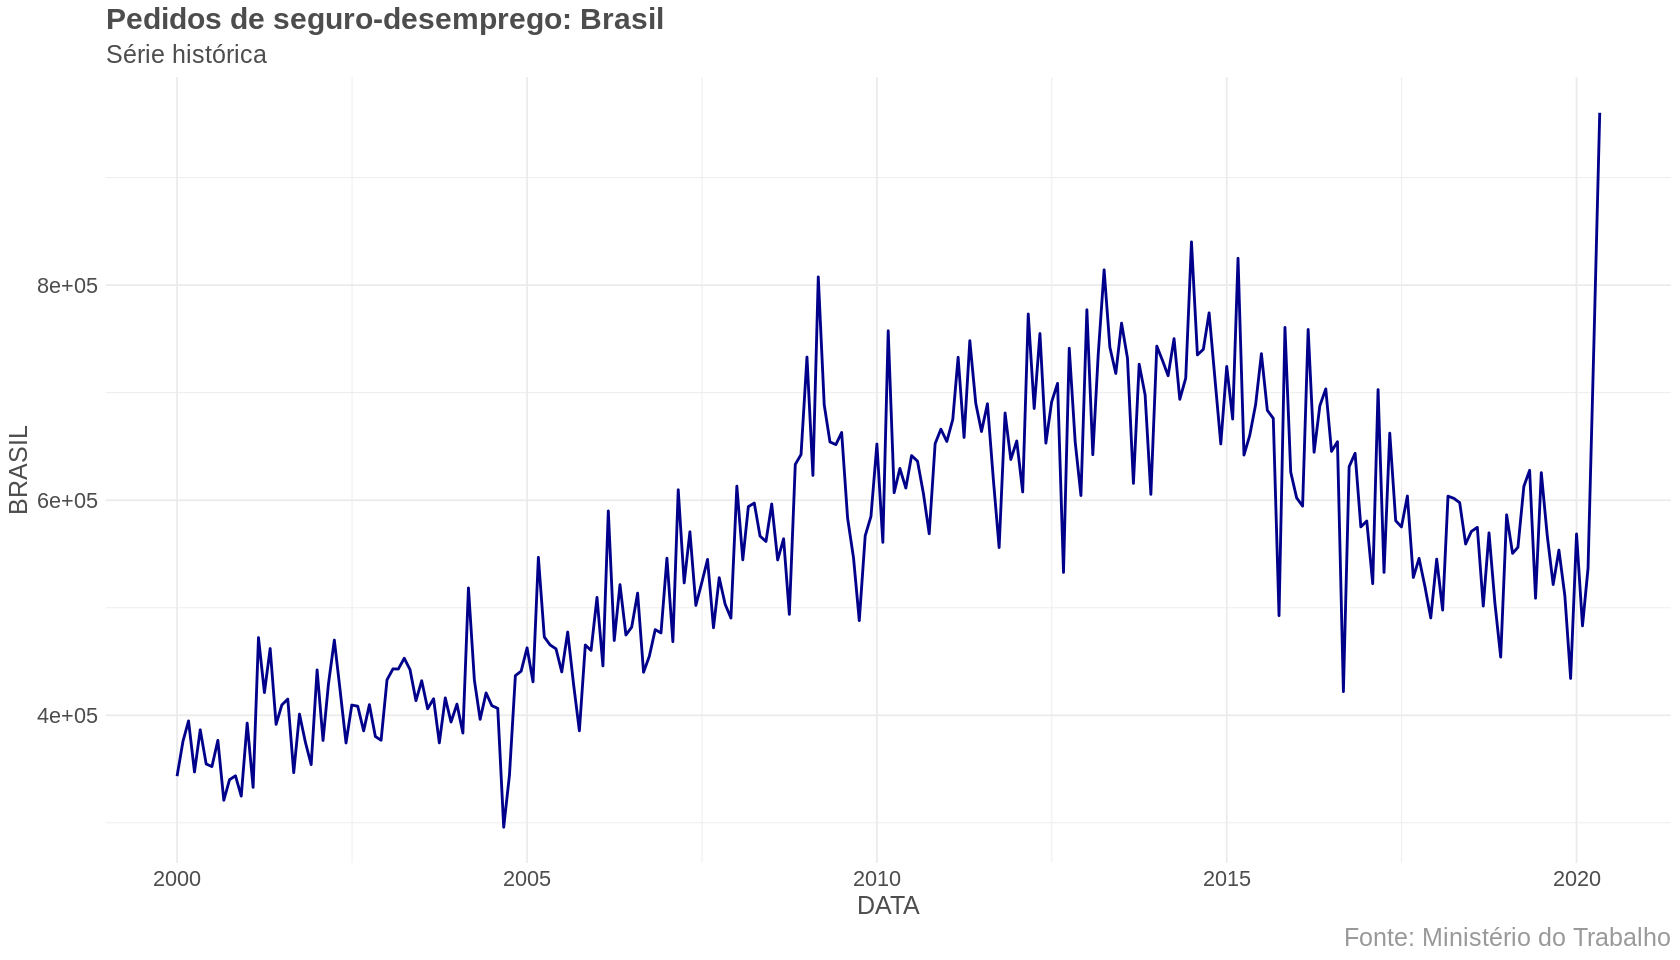

In [235]:
# usamos ggplot para fazer o gráfico dos valores para o Brasil
ggplot(seguro_desemp, aes(x = DATA, y = BRASIL))+
  geom_line(size=.8, colour='darkblue')+
   labs(title='Pedidos de seguro-desemprego: Brasil',
 subtitle='Série histórica', xlab = "Período", ylab="Pedidos (mil)",
 caption='Fonte: Ministério do Trabalho') + theme

## Análise por região

Analisaremos agora a série por região. Para tanto, foram criados subsets das regiões do país. 

In [185]:
# Criação de subsets por região e da variável de resumo da série com o nome da região
# região norte
seg_desemp_norte = seguro_desemp %>%
  select(DATA, ACRE, AMAPA, AMAZONAS, PARA, RONDONIA, RORAIMA)  %>%  
  mutate(NORTE = ACRE + AMAPA + AMAZONAS + PARA + RONDONIA + RORAIMA)

# região nordeste
seg_desemp_nordeste = seguro_desemp %>%
  select(DATA, ALAGOAS, BAHIA, CEARA, MARANHAO, PARAIBA, PERNAMBUCO, PIAUI, RIO_GRANDE_NORTE = 'RIO GRANDE DO NORTE', SERGIPE) %>%
  mutate(NORDESTE = ALAGOAS + BAHIA + CEARA + MARANHAO + PARAIBA + PERNAMBUCO + PIAUI + RIO_GRANDE_NORTE + SERGIPE)

# região centro-oeste
seg_desemp_centroeste = seguro_desemp %>%
  select(DATA, DISTRITO_FEDERAL = 'DISTRITO FEDERAL', GOIAS, MATO_GROSSO = 'MATO GROSSO', MATO_GROSSO_SUL = 'MATO GROSSO DO SUL', TOCANTINS) %>%
  mutate(CENTROESTE = DISTRITO_FEDERAL + GOIAS+ MATO_GROSSO + MATO_GROSSO_SUL + TOCANTINS)

# região sudeste
seg_desemp_sudeste = seguro_desemp %>%
  select(DATA, ESPIRITO_SANTO = 'ESPIRITO SANTO', MINAS_GERAIS = 'MINAS GERAIS', RIO_DE_JANEIRO = 'RIO DE JANEIRO', SAO_PAULO = 'SAO PAULO') %>%
  mutate(SUDESTE = ESPIRITO_SANTO + MINAS_GERAIS  + RIO_DE_JANEIRO + SAO_PAULO)

# região sul
seg_desemp_sul= seguro_desemp %>%
  select(DATA, RIO_GRANDE_SUL = 'RIO GRANDE DO SUL', SANTA_CATARINA = 'SANTA CATARINA', PARANA) %>%
  mutate(SUL = RIO_GRANDE_SUL + SANTA_CATARINA + PARANA)

O gráfico seguinte revela o comportamento das solicitações por região. Note que há um subito aumento em meados de 2020. É provável que este fenômeno seja explicado pela consequência econômica da pandemia COVID-19.

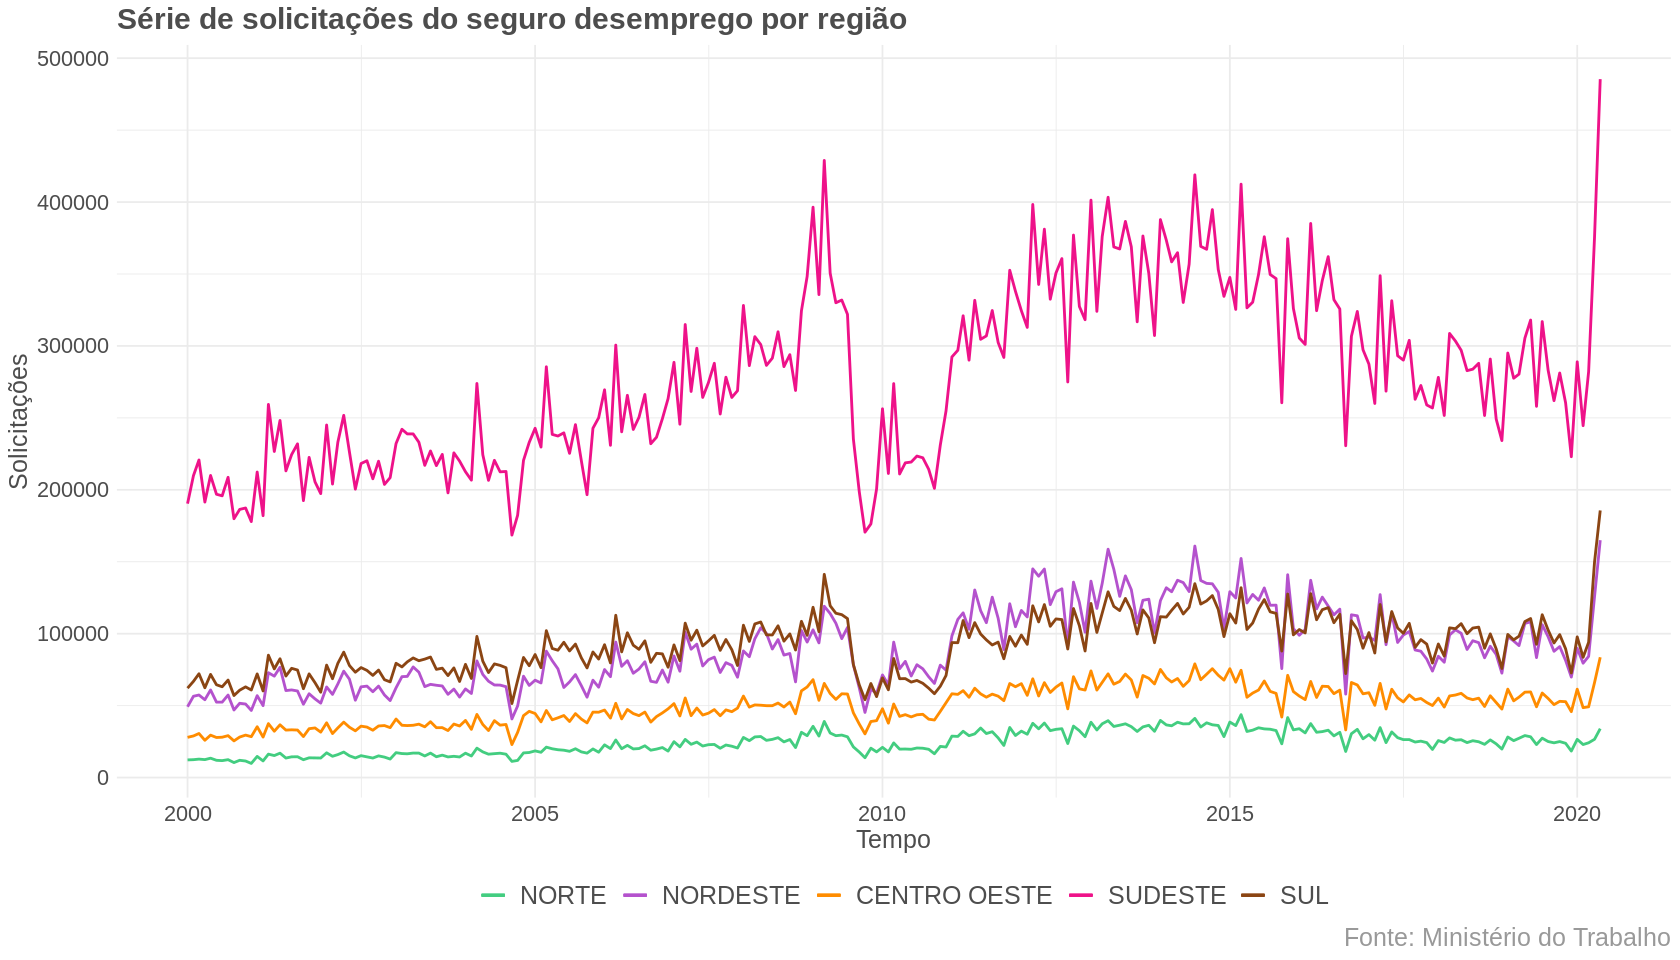

In [186]:
# Plot da série de solicitações do seguro desemprego por região
ggplot(seguro_desemp, aes(x = DATA))+
  geom_line(aes(y = seg_desemp_norte$NORTE, colour='seagreen3'), size=.8 ) +
  geom_line(aes(y = seg_desemp_nordeste$NORDESTE, colour='mediumorchid3'), size=.8) +
  geom_line(aes(y = seg_desemp_centroeste$CENTROESTE, colour='darkorange'), size=.8) +
  geom_line(aes(y = seg_desemp_sudeste$SUDESTE, colour='deeppink2'), size=.8) +
  geom_line(aes(y = seg_desemp_sul$SUL, colour='chocolate4'), size=.8) +
  scale_y_continuous(labels = function(x) format(x, scientific = FALSE)) + 
  labs(title = 'Série de solicitações do seguro desemprego por região',
         x = 'Tempo', 
         y = 'Solicitações', 
         caption = 'Fonte: Ministério do Trabalho') +
  scale_color_identity(
           name = " ",
           breaks = c('seagreen3','mediumorchid3','darkorange','deeppink2','chocolate4'),
           labels = c('NORTE','NORDESTE','CENTRO OESTE','SUDESTE', 'SUL'),
           guide = "legend"
         ) +
  
  theme + theme(legend.position="bottom")


Vamos analisar mais de perto cada região com seus respectivos estados. 

### Norte



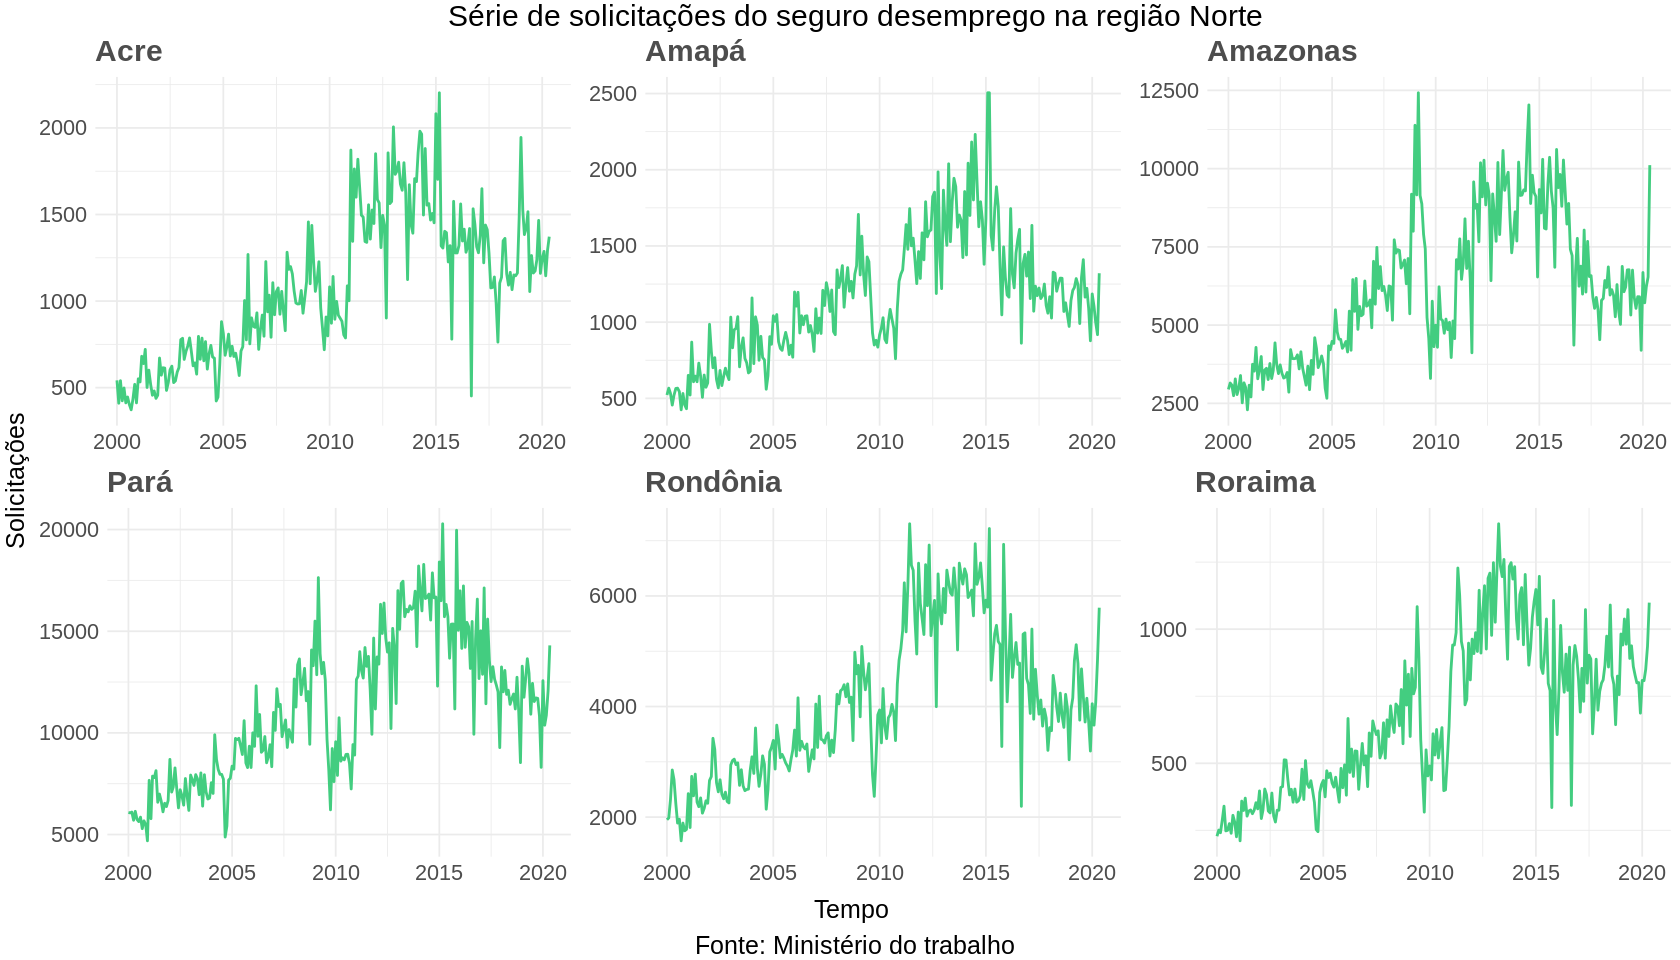

In [187]:
# Acre
p1 = ggplot(seg_desemp_norte, aes(x = DATA, y = ACRE)) +
      geom_line(color = "seagreen3", size=0.8) +
      labs(title = 'Acre') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# AMAPA
p2 = ggplot(seg_desemp_norte, aes(x = DATA, y = AMAPA)) +
      geom_line(color = "seagreen3", size=0.8) +
      labs(title = 'Amapá') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# AMAZONAS
p3 = ggplot(seg_desemp_norte, aes(x = DATA, y = AMAZONAS)) +
      geom_line(color = "seagreen3", size=0.8) +
      labs(title = 'Amazonas') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# PARA
p4 = ggplot(seg_desemp_norte, aes(x = DATA, y = PARA)) +
      geom_line(color = "seagreen3", size=0.8) +
      labs(title = 'Pará') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# RONDONIA
p5 = ggplot(seg_desemp_norte, aes(x = DATA, y = RONDONIA)) +
      geom_line(color = "seagreen3", size=0.8) +
      labs(title = 'Rondônia') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# RORAIMA
p6 = ggplot(seg_desemp_norte, aes(x = DATA, y = RORAIMA)) +
      geom_line(color = "seagreen3", size=0.8) +
      labs(title = 'Roraima') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())

grid.arrange(p1, p2, p3, p4, p5, p6, nrow = 2, 
             top = text_grob('Série de solicitações do seguro desemprego na região Norte', size = 18), 
             bottom = text_grob('Tempo \nFonte: Ministério do trabalho', size = 15),
             left = text_grob('Solicitações', size = 15, rot = 90))
      

### Nordeste

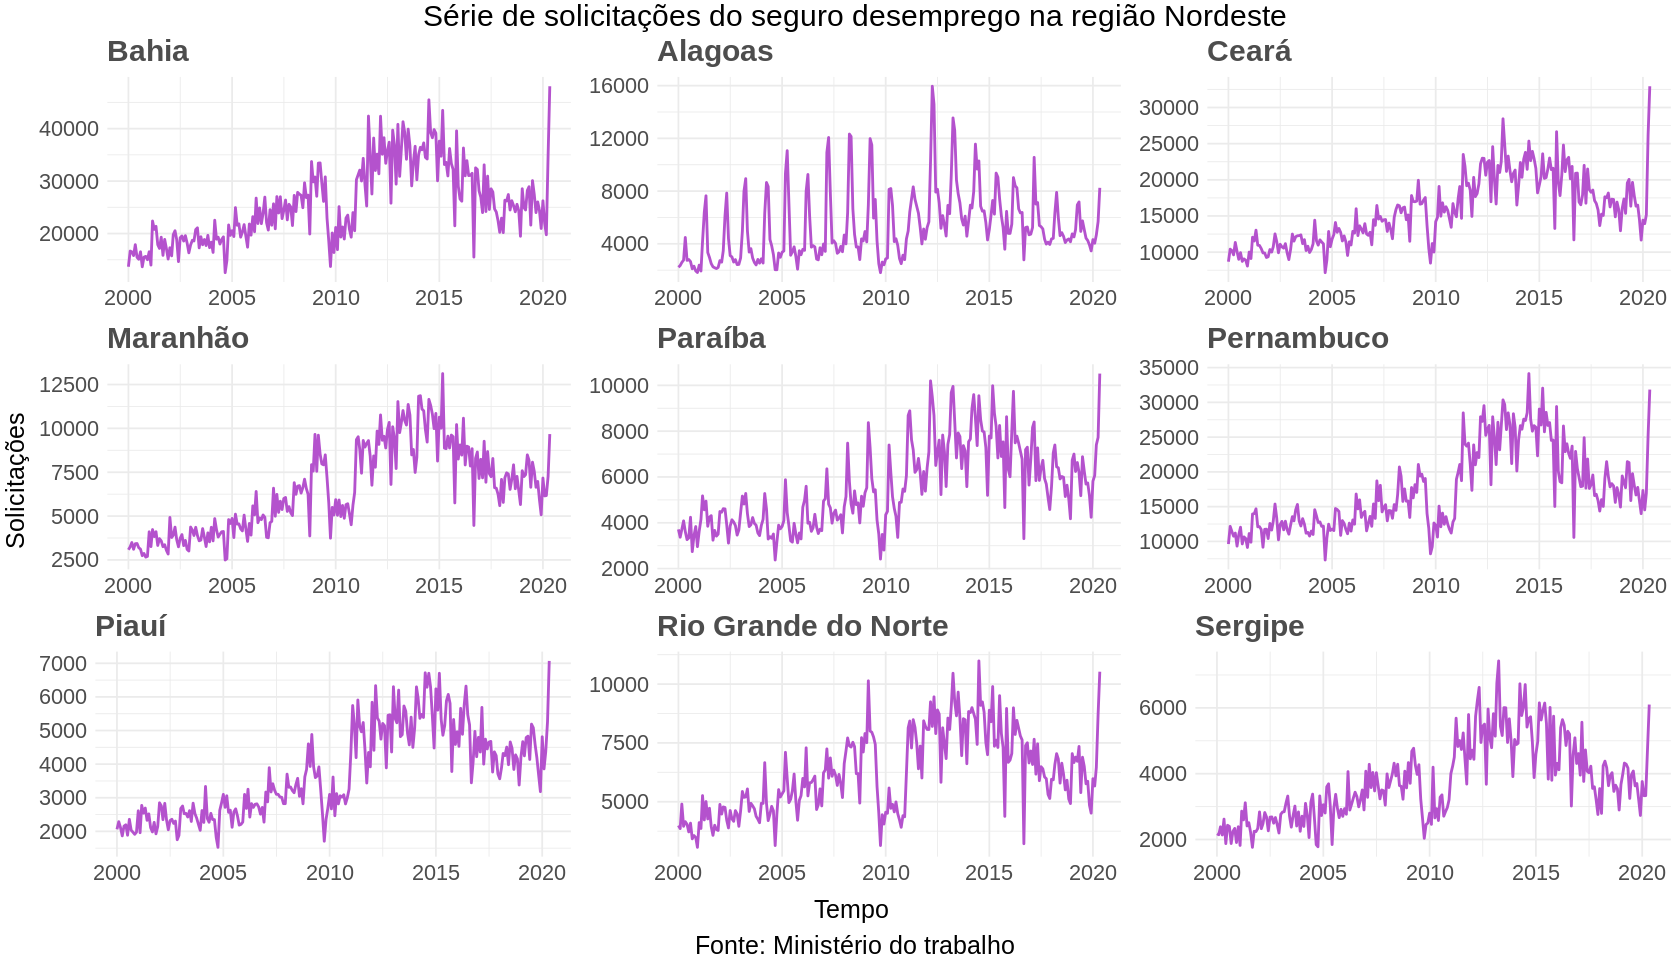

In [188]:
# BAHIA
p1 = ggplot(seg_desemp_nordeste, aes(x = DATA, y = BAHIA)) +
      geom_line(color = "mediumorchid3", size=0.8) +
      labs(title = 'Bahia') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# ALAGOAS
p2 = ggplot(seg_desemp_nordeste, aes(x = DATA, y = ALAGOAS)) +
      geom_line(color = "mediumorchid3", size=0.8) +
      labs(title = 'Alagoas') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# CEARA
p3 = ggplot(seg_desemp_nordeste, aes(x = DATA, y = CEARA)) +
      geom_line(color = "mediumorchid3", size=0.8) +
      labs(title = 'Ceará') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# MARANHAO
p4 = ggplot(seg_desemp_nordeste, aes(x = DATA, y = MARANHAO)) +
      geom_line(color = "mediumorchid3", size=0.8) +
      labs(title = 'Maranhão') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# PARAIBA
p5 = ggplot(seg_desemp_nordeste, aes(x = DATA, y = PARAIBA)) +
      geom_line(color = "mediumorchid3", size=0.8) +
      labs(title = 'Paraíba') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# PERNAMBUCO
p6 = ggplot(seg_desemp_nordeste, aes(x = DATA, y = PERNAMBUCO)) +
      geom_line(color = "mediumorchid3", size=0.8) +
      labs(title = 'Pernambuco') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# PIAUI
p7 = ggplot(seg_desemp_nordeste, aes(x = DATA, y = PIAUI)) +
      geom_line(color = "mediumorchid3", size=0.8) +
      labs(title = 'Piauí') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# RIO GRANDE DO NORTE
p8 = ggplot(seg_desemp_nordeste, aes(x = DATA, y = RIO_GRANDE_NORTE)) +
      geom_line(color = "mediumorchid3", size=0.8) +
      labs(title = 'Rio Grande do Norte') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# SERGIPE
p9 = ggplot(seg_desemp_nordeste, aes(x = DATA, y = SERGIPE)) +
      geom_line(color = "mediumorchid3", size=0.8) +
      labs(title = 'Sergipe') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, nrow = 3, 
             top = text_grob('Série de solicitações do seguro desemprego na região Nordeste', size = 18), 
             bottom = text_grob('Tempo \nFonte: Ministério do trabalho', size = 15),
             left = text_grob('Solicitações', size = 15, rot = 90))

### Centro-oeste

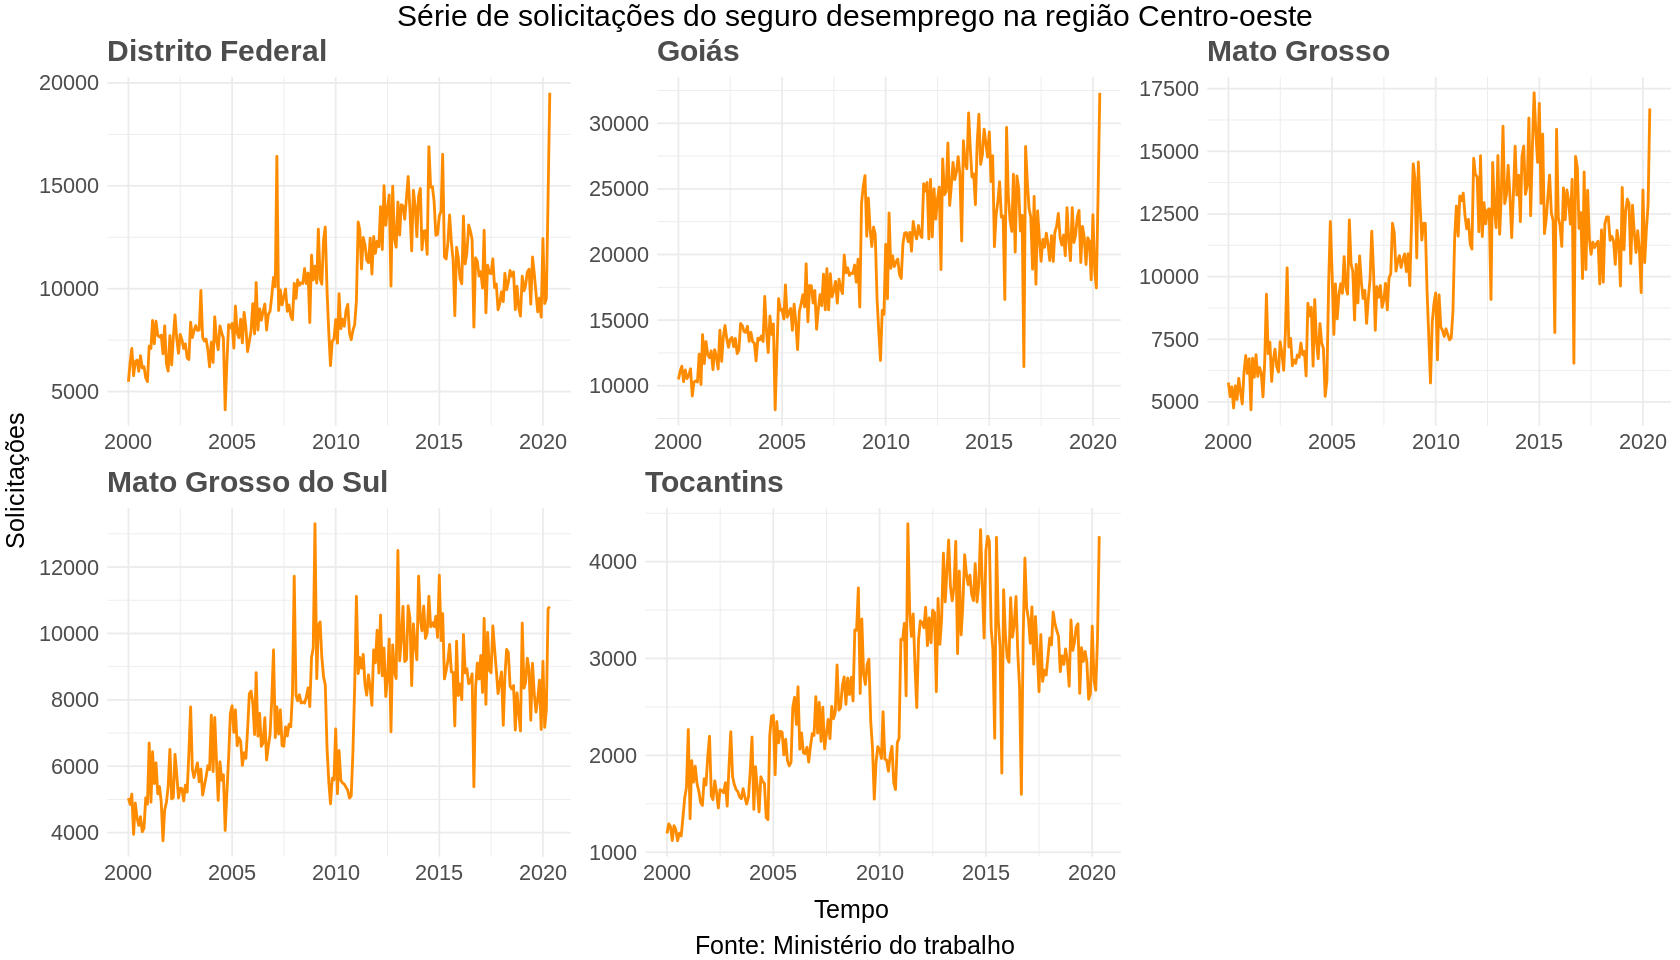

In [189]:
# DISTRITO FEDERAL
p1 = ggplot(seg_desemp_centroeste, aes(x = DATA, y = DISTRITO_FEDERAL)) +
      geom_line(color = "darkorange", size=0.8) +
      labs(title = 'Distrito Federal') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# GOIAS
p2 = ggplot(seg_desemp_centroeste, aes(x = DATA, y = GOIAS)) +
      geom_line(color = "darkorange", size=0.8) +
      labs(title = 'Goiás') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# MATO GROSSO
p3 = ggplot(seg_desemp_centroeste, aes(x = DATA, y = MATO_GROSSO)) +
      geom_line(color = "darkorange", size=0.8) +
      labs(title = 'Mato Grosso') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# MATO_GROSSO_SUL
p4 = ggplot(seg_desemp_centroeste, aes(x = DATA, y = MATO_GROSSO_SUL)) +
      geom_line(color = "darkorange", size=0.8) +
      labs(title = 'Mato Grosso do Sul') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# TOCANTINS
p5 = ggplot(seg_desemp_centroeste, aes(x = DATA, y = TOCANTINS)) +
      geom_line(color = "darkorange", size=0.8) +
      labs(title = 'Tocantins') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())

grid.arrange(p1, p2, p3, p4, p5, nrow = 2, 
             top = text_grob('Série de solicitações do seguro desemprego na região Centro-oeste', size = 18), 
             bottom = text_grob('Tempo \nFonte: Ministério do trabalho', size = 15),
             left = text_grob('Solicitações', size = 15, rot = 90))

### Sudestes

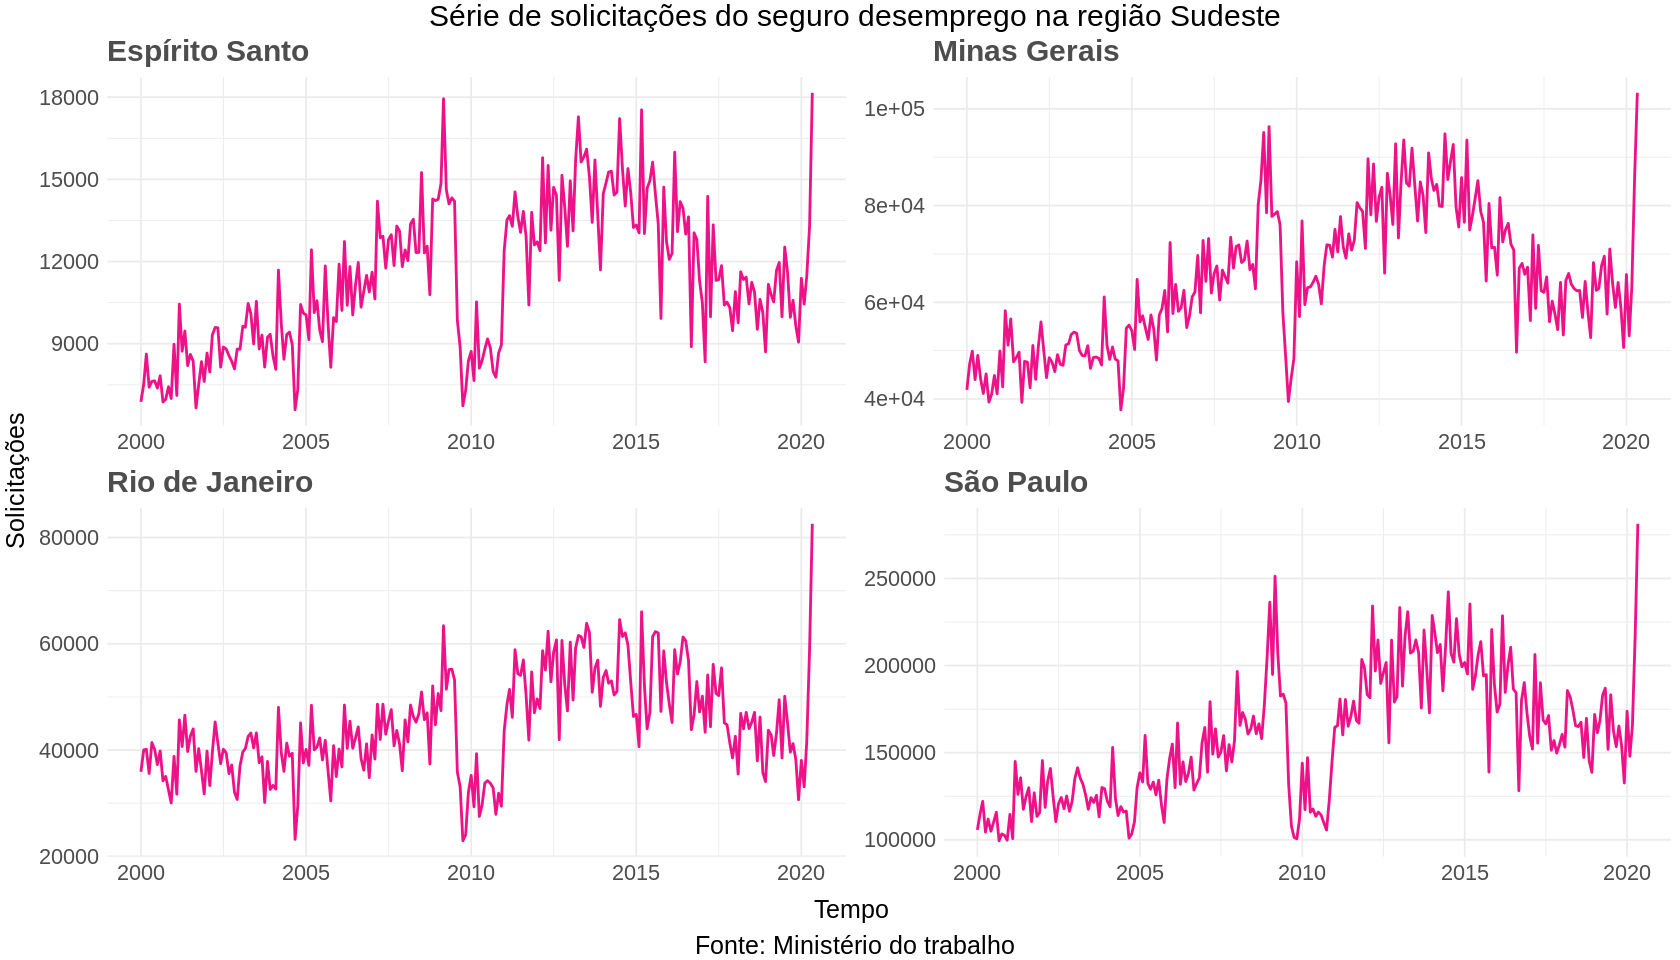

In [191]:
# ESPIRITO SANTO
p1 = ggplot(seg_desemp_sudeste, aes(x = DATA, y = ESPIRITO_SANTO)) +
      geom_line(color = "deeppink2", size=0.8) +
      labs(title = 'Espírito Santo') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# MINAS GERAIS
p2 = ggplot(seg_desemp_sudeste, aes(x = DATA, y = MINAS_GERAIS)) +
      geom_line(color = "deeppink2", size=0.8) +
      labs(title = 'Minas Gerais') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# RIO DE JANEIRO
p3 = ggplot(seg_desemp_sudeste, aes(x = DATA, y = RIO_DE_JANEIRO)) +
      geom_line(color = "deeppink2", size=0.8) +
      labs(title = 'Rio de Janeiro') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# SAO PAULO
p4 = ggplot(seg_desemp_sudeste, aes(x = DATA, y = SAO_PAULO)) +
      geom_line(color = "deeppink2", size=0.8) +
      labs(title = 'São Paulo') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())

grid.arrange(p1, p2, p3, p4, nrow = 2, 
             top = text_grob('Série de solicitações do seguro desemprego na região Sudeste', size = 18), 
             bottom = text_grob('Tempo \nFonte: Ministério do trabalho', size = 15),
             left = text_grob('Solicitações', size = 15, rot = 90))


### Sul

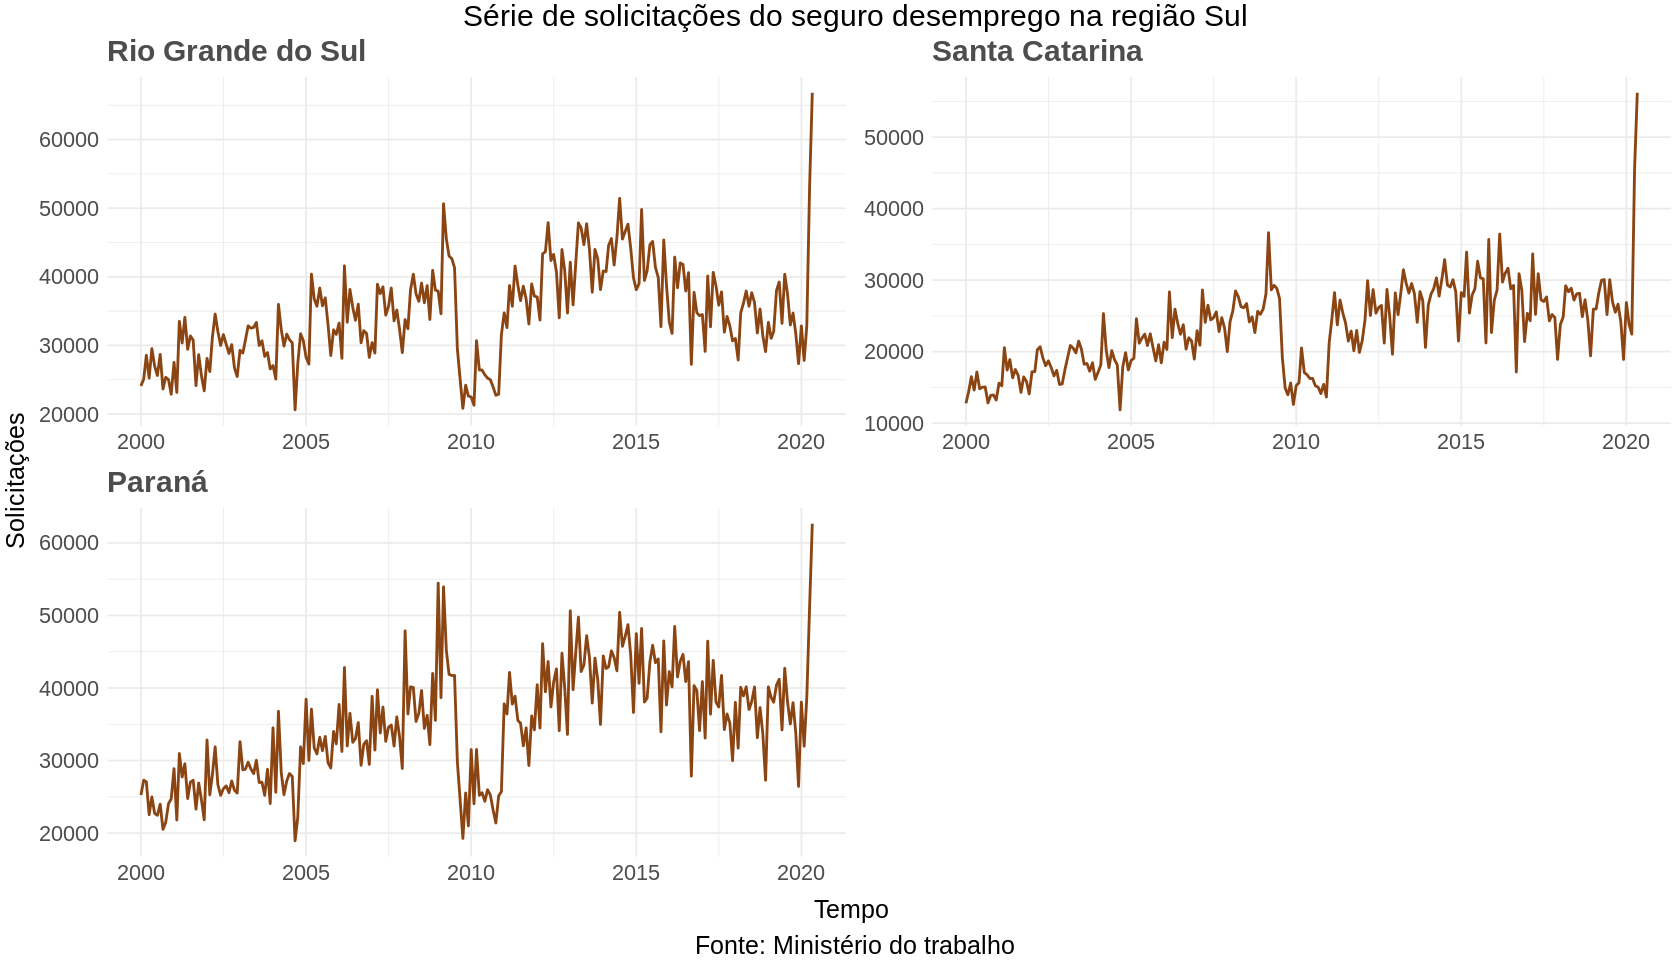

In [193]:
# RIO GRANDE DO SUL
p1 = ggplot(seg_desemp_sul, aes(x = DATA, y = RIO_GRANDE_SUL)) +
      geom_line(color = "chocolate4", size=0.8) +
      labs(title = 'Rio Grande do Sul') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# SANTA CATARINA 
p2 = ggplot(seg_desemp_sul, aes(x = DATA, y = SANTA_CATARINA )) +
      geom_line(color = "chocolate4", size=0.8) +
      labs(title = 'Santa Catarina') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())
# PARANA
p3 = ggplot(seg_desemp_sul, aes(x = DATA, y = PARANA)) +
      geom_line(color = "chocolate4", size=0.8) +
      labs(title = 'Paraná') + 
      theme  + theme(axis.title.x = element_blank(), axis.title.y = element_blank())


grid.arrange(p1, p2, p3, nrow = 2, 
             top = text_grob('Série de solicitações do seguro desemprego na região Sul', size = 18), 
             bottom = text_grob('Tempo \nFonte: Ministério do trabalho', size = 15),
             left = text_grob('Solicitações', size = 15, rot = 90))




---

# Índices econômicos

Nesta última seção vamos visualizar a série temporal da expectativa anual dos índices: PIB total, IPCA, taxa de câmbio e Selic. 

Os dados são provenientes do Banco Central do Brasil, e a interface utilizada é implementada pelo pacote [Pacote RBCB](https://github.com/wilsonfreitas/rbcb).


## Importando e conhecendo os dados

O pacote pode ser instalado diretamente do GitHub. 

In [196]:
# https://github.com/wilsonfreitas/rbcb
devtools::install_github("wilsonfreitas/rbcb")
library(rbcb)

Skipping install of 'rbcb' from a github remote, the SHA1 (b70fb091) has not changed since last install.
  Use `force = TRUE` to force installation



Uma vez instalado, podemos importar a série e as respectivas variáveis de interesse. 

In [199]:
# Carrega os dados da série de expectiva anual do mercado, considerando alguns índices
market_expec = get_annual_market_expectations(c('PIB Total', 'IPCA', 'Taxa de câmbio', 'Meta para taxa over-selic'),
                                              start_date = '2012-01-01')
# Estrutura da série
head(market_expec)
# Dimensões
cat("Número de linhas: ", dim(market_expec)[1])
cat("\nNúmero de colunas: ", dim(market_expec)[2])

indic,indic_detail,date,reference_year,mean,median,sd,coefvar,min,max,respondents,base
<chr>,<chr>,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
IPCA,NA,2020-07-17,2020,1.73,1.72,0.29,16.76,0.82,2.90,108,0
IPCA,NA,2020-07-17,2024,3.28,3.25,0.24,7.32,3.00,3.85,70,0
IPCA,NA,2020-07-17,2021,3.07,3.00,0.42,13.68,2.09,4.44,101,0
IPCA,NA,2020-07-17,2022,3.41,3.50,0.23,6.74,2.40,3.90,87,0
IPCA,NA,2020-07-17,2023,3.34,3.25,0.20,5.99,2.70,3.85,79,0
IPCA,NA,2020-07-17,2020,1.76,1.78,0.27,15.34,1.14,2.90,53,1


Número de linhas:  72582
Número de colunas:  12

## Análise das expectativas anuais de mercado 

Por hora, nos interessa avaliar e visualizar o comportamento de métricas como média, mediana e desvio padrão dos índices supracitados. Plotaremos a expectativa de mercado para 2021, considerando o mesmo período já percorrido em 2020.

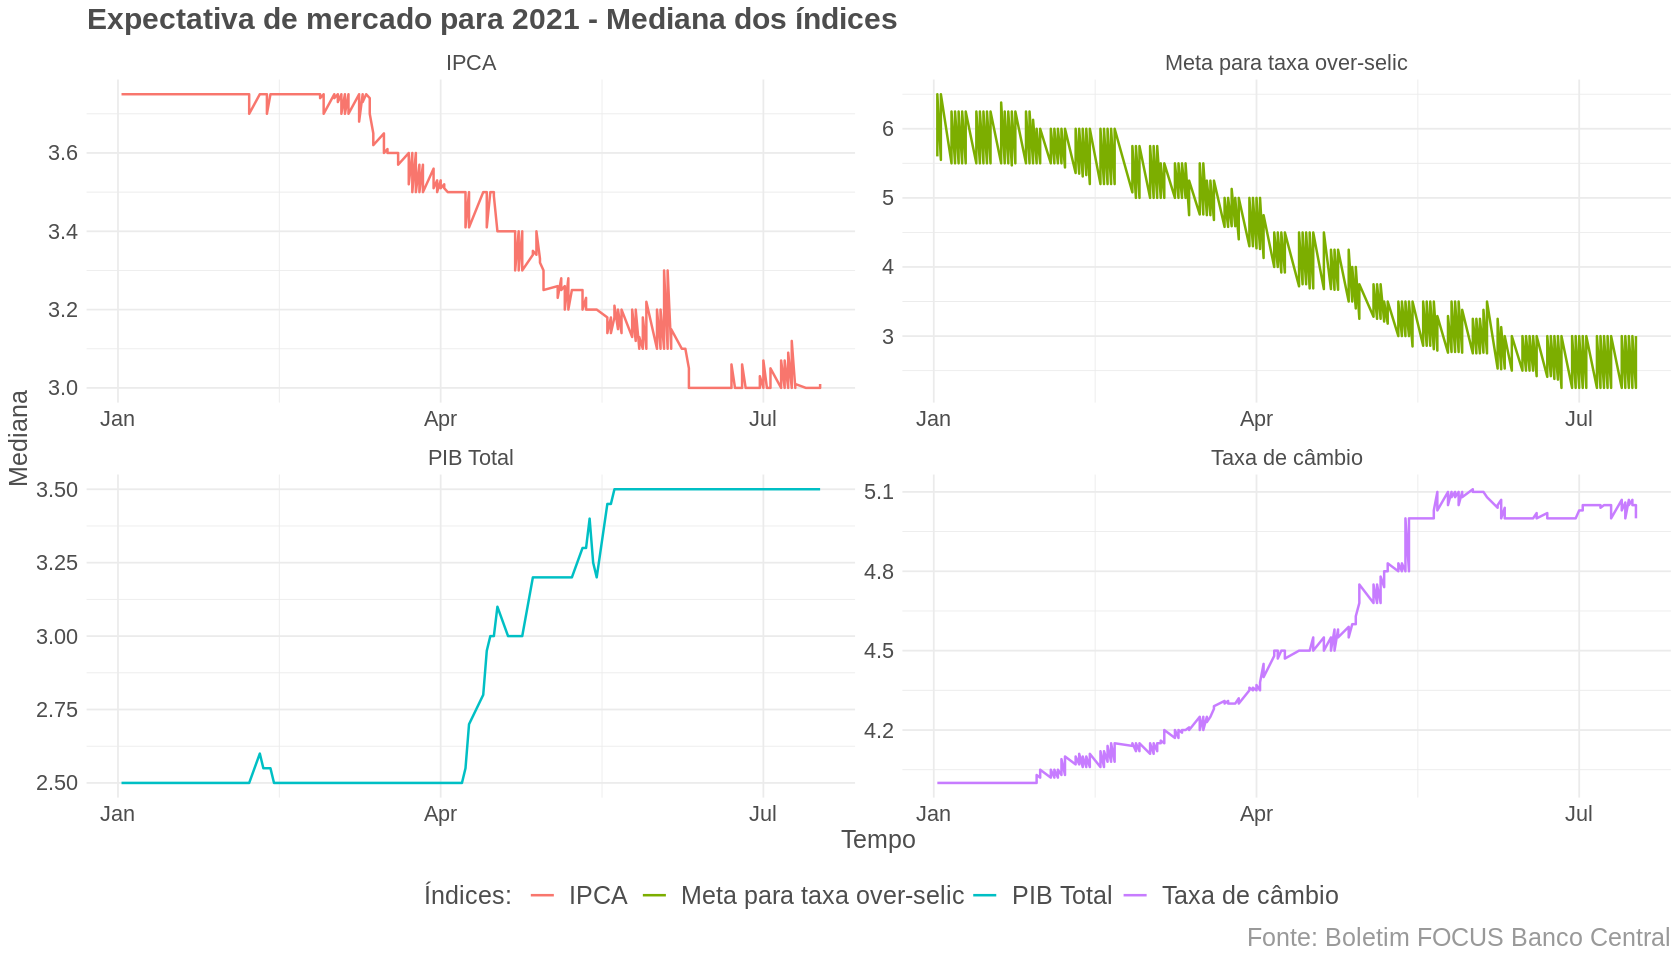

In [223]:
# Plotagem da expectativa de mercado para 2021, considerando os índices de interesse e as suas medianas
market_expec %>%
  # Filtra as previsões para 2021 a partir do mesmo período já percorrido em 2020
  filter(date > '2020-01-01', reference_year == '2021')  %>%
  ggplot(aes(x = date, y = median)) +
    geom_line(aes(color = indic), size = 0.7) + 
    facet_wrap(~ indic, nrow = 2, scales = 'free') +
    labs(title = 'Expectativa de mercado para 2021 - Mediana dos índices',
         x = 'Tempo', 
         y = 'Mediana', 
         caption = 'Fonte: Boletim FOCUS - Banco Central') +
    scale_color_discrete(name = "Índices: ") + 
    theme + theme(legend.position="bottom")  
    

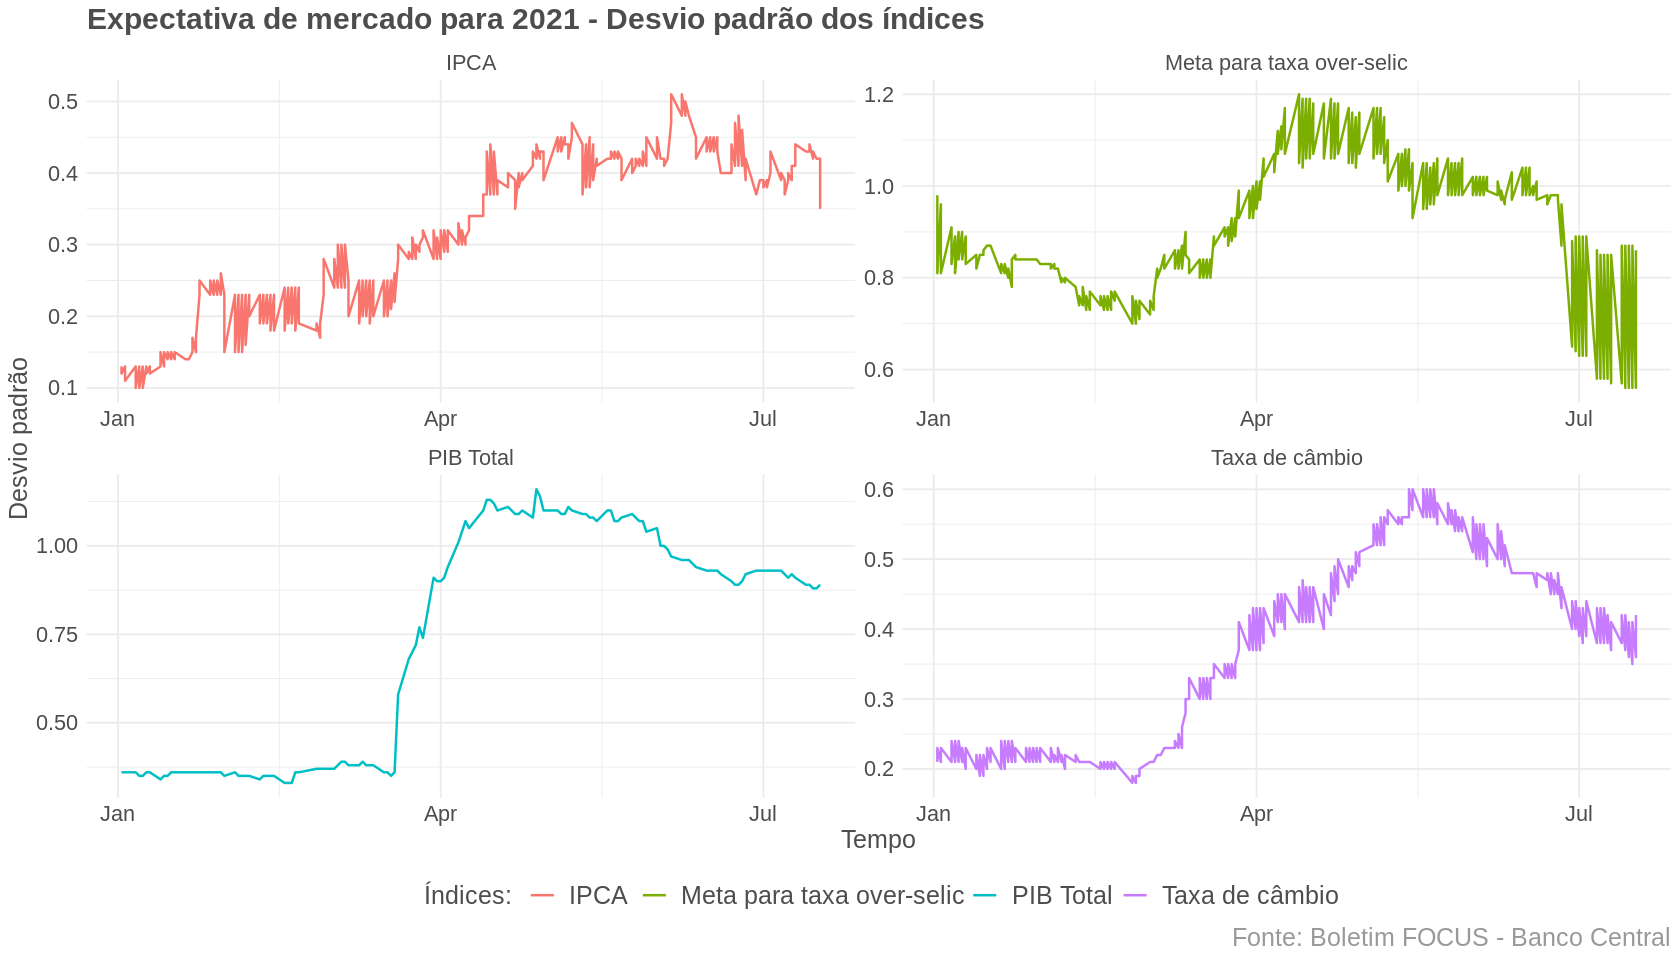

In [225]:
# Plotagem da expectativa de mercado para 2021, considerando os índices de interesse e os seus desvios padrão
market_expec %>%
  # Filtra as previsões para 2021 a partir do mesmo período já percorrido em 2020
  filter(date > '2020-01-01', reference_year == '2021')  %>%
  ggplot(aes(x = date, y = sd)) +
    geom_line(aes(color = indic), size = 0.7) + 
    facet_wrap(~ indic, nrow = 2, scales = 'free') +
    labs(title = 'Expectativa de mercado para 2021 - Desvio padrão dos índices',
         x = 'Tempo', 
         y = 'Desvio padrão', 
         caption = 'Fonte: Boletim FOCUS - Banco Central') +
    scale_color_discrete(name = "Índices: ") + 
    theme + theme(legend.position="bottom")  

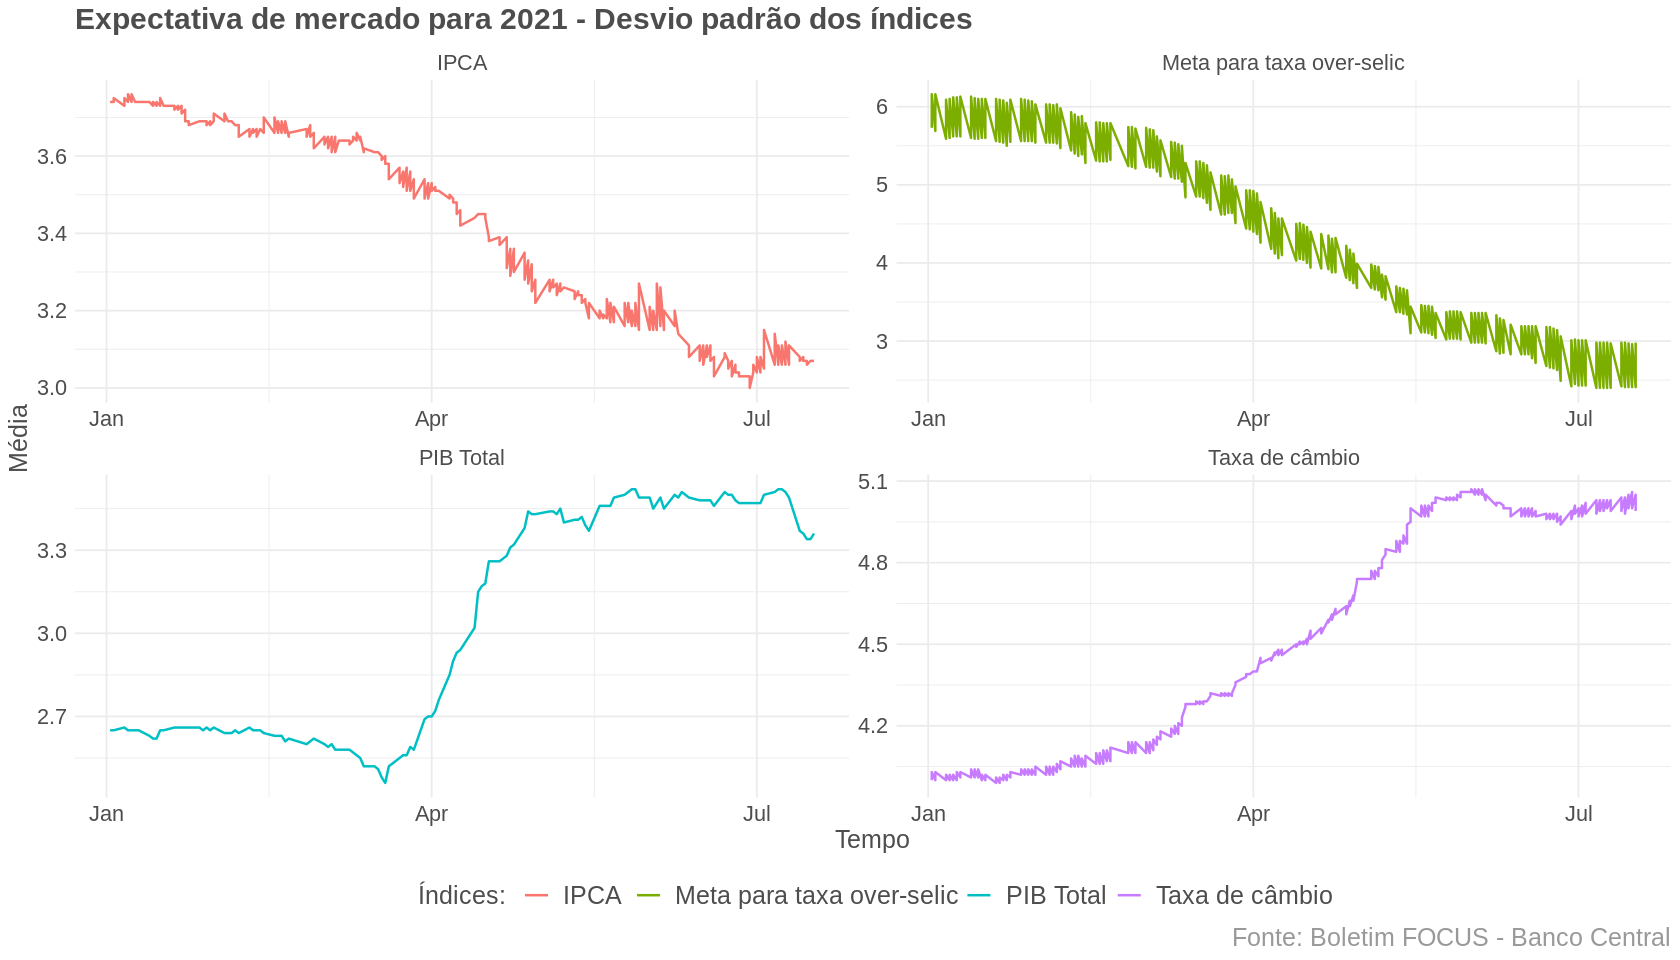

In [229]:
# Plotagem da expectativa de mercado para 2021, considerando os índices de interesse e as suas médias
market_expec %>%
  # Filtra as previsões para 2021 a partir do mesmo período já percorrido em 2020
  filter(date > '2020-01-01', reference_year == '2021')  %>%
  ggplot(aes(x = date, y = mean)) +
    geom_line(aes(color = indic), size = 0.7) + 
    facet_wrap(~ indic, nrow = 2, scales = 'free') +
    labs(title = 'Expectativa de mercado para 2021 - Desvio padrão dos índices',
         x = 'Tempo', 
         y = 'Média', 
         caption = 'Fonte: Boletim FOCUS - Banco Central') +
    scale_color_discrete(name = "Índices: ") + 
    theme + theme(legend.position="bottom")



---
Referências
==

- [Ajuste Sazonal - QWE Wiki](https://pt.qwe.wiki/wiki/Seasonal_adjustment)
- [Dados Seguro Desemprego - PROGRAMA DE DISSEMINAÇÃO DAS ESTATÍSTICAS DO TRABALHO](http://pdet.mte.gov.br/images/Seguro-Desemprego/Segunda%20Quinzena%20de%20Maio/3-%20S%C3%A9rie%20Hist%C3%B3rica%20do%20Seguro-Desemprego%20-%202000%20a%202020%20-%20mensal.xlsx)

- [Pacote RBCB - Dados do Banco Central do Brasil](https://github.com/wilsonfreitas/rbcb)

- [Sistema IBGE de Recuperação Automática](https://sidra.ibge.gov.br/home/ipca/brasil)
- [Pacote SIDRAR](https://github.com/rpradosiqueira/sidrar)
- [Quick correlation matrix heatmap - STHDA](http://www.sthda.com/english/wiki/ggplot2-quick-correlation-matrix-heatmap-r-software-and-data-visualization)